# 1.

Primero se expondrán las respuestas de preguntas no-bonus.

In [229]:
from scipy.integrate import solve_ivp
from scipy.optimize import fsolve
import numpy as np
from scipy.optimize import minimize_scalar
import matplotlib.pyplot as plt
import matplotlib.pyplot as pltp
import pandas as pd

Para los siguientes sistemas considere que para las reacciones:
$$
C_6H_6 + Cl_2 -> C_6H_6Cl + HCl , k1 = 0.412 L/ (kmol h)\\
C_6H_5Cl + Cl_2 -> C_6H_4Cl_2 + HCl, k2 = 0.055 L/ (kmol h)
$$
- A: $C_6H_6$ (Benceno)
- B: $Cl_2$ (Cloro)
- C: $HCl$ (HCl)
- D: $C_6H_6 Cl$ (Monoclorobenceno)
- E: $C_6H_4Cl_2$ (Diclorobenceno)


## A

In [230]:

def pfr_dV(t, x, k1, k2, v):
    '''
    Define el sistema de ecuciones diferenciales para el reactor de flujo pistón (PFR).
    Este toma la forma 
    dF/dV = r
    donde F es el vector de flujos molares y r es el vector de velocidades de reacción.
    ---
    Reference:
    Fogler, H. S. (2016). Elements of chemical reaction engineering (Fifth edition). Prentice-Hall, Pearson.
    Pagina 16.
    
    '''
    Ca, Cb, Cc, Cd, Ce = x
    dCa_dV = 1/v * (-k1 * Ca * Cb)
    dCb_dV = 1/v * (-k1 * Ca * Cb - k2 * Cb * Cd)
    dCc_dV = 1/v * (k1 * Ca * Cb + k2 * Cb * Cd)
    dCd_dV = 1/v * (k1 * Ca * Cb - k2 * Cb * Cd)
    dCe_dV = 1/v * (k2 * Cb * Cd)
    return [dCa_dV, dCb_dV, dCc_dV, dCd_dV, dCe_dV]

# definimos los valores que conocemos
# constantes de velocidad
k1 = 0.412 # L/kmol h
k2 = 0.055 # L/kmol h
# concentraciones del flujo de entrada
Ca0 = 1 # kmol / L
Cb0 = 5 # kmol / L
Cc0 = 0 # kmol / L
Cd0 = 0 # kmol / L
Ce0 = 0 # kmol / L
# valor del flujo de entrada
v0 = 10 # m^3/h
# ahora escalamos para que v0 quede en unidades de L/h
v0 = v0 * 1000 # L/h
# tamaño de reactores
V1 = 5.56 # m^3
V2 = 11.607 # m^3
# ahora escalamos para que V1 y V2 queden en unidades de L
V1 = V1 * 1000 # L
V2 = V2 * 1000 # L
## debido a que son dos pfr en serie, el volumen total es:
V_total = V1 + V2 # L


Es posible simplificar la solución de este sistema al pre-calcular los flujos a través de las corrientes, tomando en cuenta el valor inicial de la corriente de reciclo.

In [231]:
def define_volumes(v0, vR):
    v0 = v0
    vR = vR
    v1 = v0 + vR
    v2 = v1
    v3 = v0 # estado estacionario
    return v0, v1, v2, v3, vR

c0 = [Ca0, Cb0, Cc0, Cd0, Ce0]  # condiciones iniciales

# supuesto inicial para corriente de reciclo
vrs = np.linspace(100, v0*2, 100) # L/h
dict_results = {}

# empezamos resolviendo el sistema
for vr in vrs:
    converged = False
    # initial guess de CaR
    CaR = 0
    v0, v1, v2, v3, vr = define_volumes(v0, vr)
    while not converged:
        # punto de mezcla 0, 1, vR
        
        Ca1 = (Ca0 * v0 + CaR * vr) / v1
        Cb1 = (Cb0 * v0 ) / v1
        # balance PFR 1 con PFR 2 en serie 
        c1 = [Ca1, Cb1, 0, 0, 0]  # condiciones iniciales pfr 1
        sol = solve_ivp(pfr_dV, [0, V_total], c1, args=(k1, k2, v1), method='BDF') # ACA TAMBIEN LO CAMBIE
        Ca2, Cb2, Cc2, Cd2, Ce2 = sol.y[:, -1]
        # balance separador de benceno
        CaR_new = (Ca2 * v2) / vr
        Cb3 = (Cb2 * v2) / v3
        Cc3 = (Cc2 * v2) / v3
        Cd3 = (Cd2 * v2) / v3
        Ce3 = (Ce2 * v2) / v3
        # convergencia
        if abs(CaR_new - CaR) < 1e-6:
            converged = True
        CaR = CaR_new
    dict_results[vr] = (Cb3, Cc3, Cd3, Ce3) # guardamos los resultados una vez convergidos


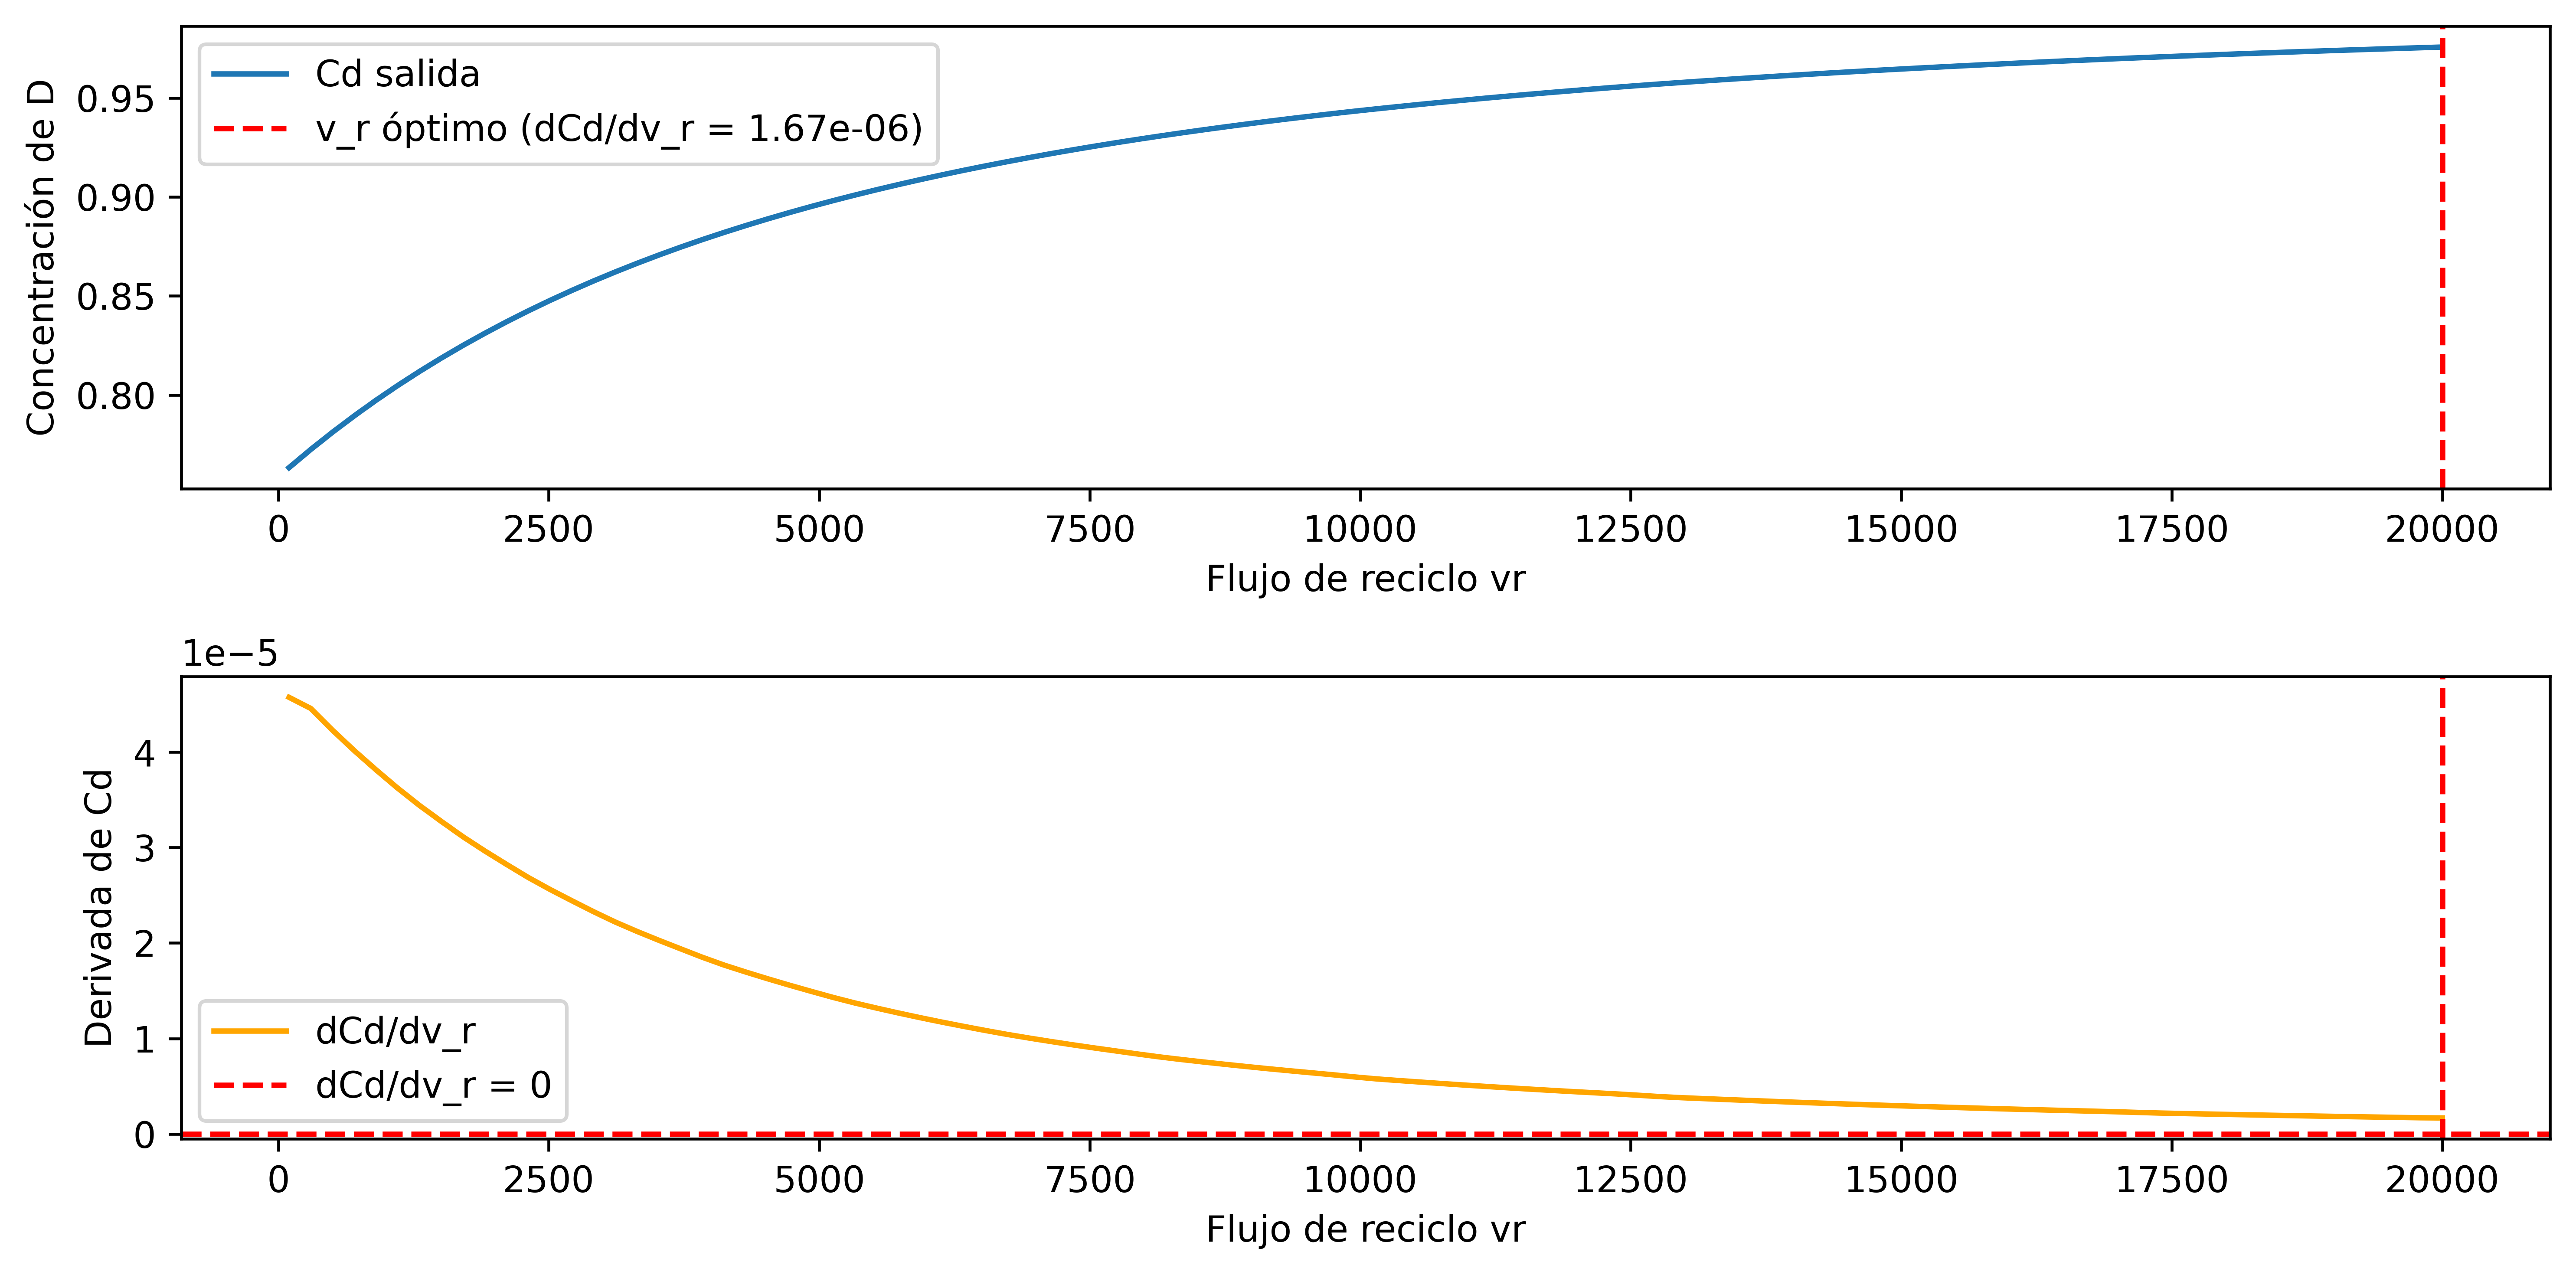

In [232]:
# calculamos cuando la concentracion de D es maxima a partir de v_r
# derivada
cdouts = np.array([dict_results[vr][2] for vr in vrs]) # concentracion de D en salida
dd_dvrs = np.gradient(cdouts, vrs)
# cerca de 0
idx_max = np.argmin(dd_dvrs) # el minimo de la derivada
vrs_opt = vrs[idx_max]
fig, ax = plt.subplots(2, 1, figsize=(10,5), dpi = 600)

ax[0].plot(vrs, cdouts, label='Cd salida')
ax[0].set_xlabel('Flujo de reciclo vr')
ax[0].set_ylabel('Concentración de D')
ax[0].axvline(vrs_opt, color='red', linestyle='--', label=f'v_r óptimo (dCd/dv_r = {dd_dvrs[idx_max]:.2e})')
ax[0].legend()

ax[1].plot(vrs, dd_dvrs, label='dCd/dv_r', color='orange')
ax[1].set_xlabel('Flujo de reciclo vr')
ax[1].set_ylabel('Derivada de Cd')
ax[1].axhline(0, color='red', linestyle='--', label='dCd/dv_r = 0')
ax[1].axvline(vrs_opt, color='red', linestyle='--')
ax[1].legend()
plt.tight_layout()

Podemos ver que la función de concentración de monoclorobenceno vs el flujo de reciclo es monotonica y creciente, por lo cual un valor alto funciona. Así, usamos un valor donde la derivada sea cercana a 0, por ejemplo, el doble de la entrada al sistema (2v0).
Así, podemos calcular los valores que se buscan.

In [233]:
def define_volumes(v0, vR):
    v0 = v0
    vR = vR
    v1 = v0 + vR
    v2 = v1
    v3 = v0 # estado estacionario
    return v0, v1, v2, v3, vR

c0 = [Ca0, Cb0, Cc0, Cd0, Ce0]  # condiciones iniciales

# supuesto inicial para corriente de reciclo
vr = 2*v0 #L/h
dict_results = {}

# empezamos resolviendo el sistema

initial_guess_caR = 0 # kmol/L
converged = False
CaR = initial_guess_caR # kmol/L
v0, v1, v2, v3, vr = define_volumes(v0, vr)
while not converged:
    # punto de mezcla 0, 1, vR
    
    Ca1 = (Ca0 * v0 + CaR * vr) / v1
    Cb1 = (Cb0 * v0 ) / v1
    # balance PFR 1 con PFR 2 en serie 
    c1 = [Ca1, Cb1, 0, 0, 0]  # condiciones iniciales pfr 1
    sol = solve_ivp(pfr_dV, [0, V_total], c1, args=(k1, k2, v1), method='LSODA')
    Ca2, Cb2, Cc2, Cd2, Ce2 = sol.y[:, -1]
    # balance separador de benceno
    CaR_new = (Ca2 * v2) / vr
    Cb3 = (Cb2 * v2) / v3
    Cc3 = (Cc2 * v2) / v3
    Cd3 = (Cd2 * v2) / v3
    Ce3 = (Ce2 * v2) / v3
    # convergencia
    if abs(CaR_new - CaR) < 1e-9:
        converged = True
    CaR = CaR_new
dict_results[vr] = (Cb3, Cc3, Cd3, Ce3) # guardamos los resultados una vez convergidos


Los valores de interés son las concentraciones de salida en la corriente 3.

In [234]:
# valores

print(f'Concentración de salida B: {Cb3:.4f} kmol/L')
print(f'Concentración de salida C: {Cc3:.4f} kmol/L')
print(f'Concentración de salida D: {Cd3:.4f} kmol/L')
print(f'Concentración de salida E: {Ce3:.4f} kmol/L')

# selectividad global del de monoclorobenceno sobre diclorobenceno
S = Cd3 / Ce3
print(f'Selectividad global de monoclorobenceno sobre diclorobenceno: {S:.4f}')

Concentración de salida B: 3.9757 kmol/L
Concentración de salida C: 1.0243 kmol/L
Concentración de salida D: 0.9757 kmol/L
Concentración de salida E: 0.0243 kmol/L
Selectividad global de monoclorobenceno sobre diclorobenceno: 40.2035


## C

Debido a que el reactor pfr con reciclo está separado del sistema con recirculación. Primero resolvemos el balance de masa del reactor PFR con reciclo.

In [235]:

def pfr_dV(t, x, k1, k2, v):
    '''
    Define el sistema de ecuciones diferenciales para el reactor de flujo pistón (PFR).
    Este toma la forma 
    dF/dV = r
    donde F es el vector de flujos molares y r es el vector de velocidades de reacción.
    ---
    Reference:
    Fogler, H. S. (2016). Elements of chemical reaction engineering (Fifth edition). Prentice-Hall, Pearson.
    Pagina 16.
    
    '''
    Ca, Cb, Cc, Cd, Ce = x
    dCa_dV = 1/v * (-k1 * Ca * Cb)
    dCb_dV = 1/v * (-k1 * Ca * Cb - k2 * Cb * Cd)
    dCc_dV = 1/v * (k1 * Ca * Cb + k2 * Cb * Cd)
    dCd_dV = 1/v * (k1 * Ca * Cb - k2 * Cb * Cd)
    dCe_dV = 1/v * (k2 * Cb * Cd)
    return [dCa_dV, dCb_dV, dCc_dV, dCd_dV, dCe_dV]

# definimos los valores que conocemos
# constantes de velocidad
k1 = 0.412 # L/kmol h
k2 = 0.055 # L/kmol h
# concentraciones del flujo de entrada
Ca0 = 1 # kmol / L
Cb0 = 5 # kmol / L
Cc0 = 0 # kmol / L
Cd0 = 0 # kmol / L
Ce0 = 0 # kmol / L
# valor del flujo de entrada
v0 = 10 # m^3/h
# ahora escalamos para que v0 quede en unidades de L/h
v0 = v0 * 1000 # L/h
# tamaño de reactores
V1 = 5.56 # m^3
V2 = 11.607 # m^3
# ahora escalamos para que V1 y V2 queden en unidades de L
V1 = V1 * 1000 # L
V2 = V2 * 1000 # L


De nuevo encontramos los flujos previo a la simulación.

In [236]:
def define_volumes(v0, vR2, R):
    v0 = v0
    v3 = v0 # estado estacionario
    vR1 = R * v3
    v1 = v0 + vR1
    v2 = (R+1) * v3
    vR2 = vR2
    v4 = v3 + vR2
    v5 = v4
    v6 = v0 # estado estacionario
    return v0, v1, v2, v3, vR1, v4, v5, v6, vR2


R_vals = np.concatenate((np.linspace(0, 1, 5),np.linspace(1, 100, 5))) # sacamos varios entre 0 hasta 1 y 1 hasta 100
vR_vals = np.linspace(100, v0*3, 50)
dict_results = {}
for vr in vR_vals: # flujo de reciclo
    for r in R_vals: # razon de reciclo
        # solucion del pfr1 con reciclo
        cR1 = np.zeros(5) # initial guess de reciclo del pfr1
        converged_pfr1 = False
        v0, v1, v2, v3, vR1, v4, v5, v6, vR2 = define_volumes(v0, vr, r) # volumenes definidos previamente
        while not converged_pfr1:
            # punto de mezcla 0, 1, vR1
            
            CaR1, CbR1, CcR1, CdR1, CeR1 = cR1
            Ca1 = (Ca0 * v0 + CaR1 * vR1) / v1
            Cb1 = (Cb0 * v0 + CbR1 * vR1) / v1
            Cc1 = (Cc0 * v0 + CcR1 * vR1) / v1
            Cd1 = (Cd0 * v0 + CdR1 * vR1) / v1
            Ce1 = (Ce0 * v0 + CeR1 * vR1) / v1
            # balance PFR 1
            sol_pfr1 = solve_ivp(pfr_dV, [0, V1], [Ca1, Cb1, Cc1, Cd1, Ce1], args=(k1, k2, v1), method='LSODA')
            Ca2, Cb2, Cc2, Cd2, Ce2 = sol_pfr1.y[:, -1]
            # balance reciclo pfr1
            Ca3 = CaR1_new = Ca2 # recordemos que las concentraciones en 2, 3, y R1 son iguales
            Cb3 = CbR1_new = Cb2
            Cc3 = CcR1_new = Cc2
            Cd3 = CdR1_new = Cd2
            Ce3 = CeR1_new = Ce2
            # convergencia pfr1
            if np.allclose([CaR1_new, CbR1_new, CcR1_new, CdR1_new, CeR1_new], cR1, atol=1e-6):
                converged_pfr1 = True
            cR1 = [CaR1_new, CbR1_new, CcR1_new, CdR1_new, CeR1_new]
        # despues de este while tenemos las concentraciones de 3
        # solución del sistema B (ver pauta)
        CaR2 = 0 # initial guess de reciclo del pfr2
        converged_B = False # convergencia del sistema B
        while not converged_B:
            # punto de mezcla 3, 4, y R2
            Ca4 = (Ca3 * v3 + CaR2 * vR2) / v4
            Cb4 = (Cb3 * v3 ) / v4
            Cc4 = (Cc3 * v3 ) / v4
            Cd4 = (Cd3 * v3 ) / v4
            Ce4 = (Ce3 * v3 ) / v4
            # balance PFR 2
            sol_pfr2 = solve_ivp(pfr_dV, [0, V2], [Ca4, Cb4, Cc4, Cd4, Ce4], args=(k1, k2, v4), method='LSODA')
            Ca5, Cb5, Cc5, Cd5, Ce5 = sol_pfr2.y[:, -1]
            # balance del separador de benceno
            CaR2_new = (Ca5 * v5) / vR2
            Cb6 = (Cb5 * v5) / v6
            Cc6 = (Cc5 * v5) / v6
            Cd6 = (Cd5 * v5) / v6
            Ce6 = (Ce5 * v5) / v6
            # convergencia sistema B
            if abs(CaR2_new - CaR2) < 1e-6:
                converged_B = True
            CaR2 = CaR2_new
        dict_results[(vr, r)] = (Cb6, Cc6, Cd6, Ce6) # guardamos los resultados una vez convergidos
            

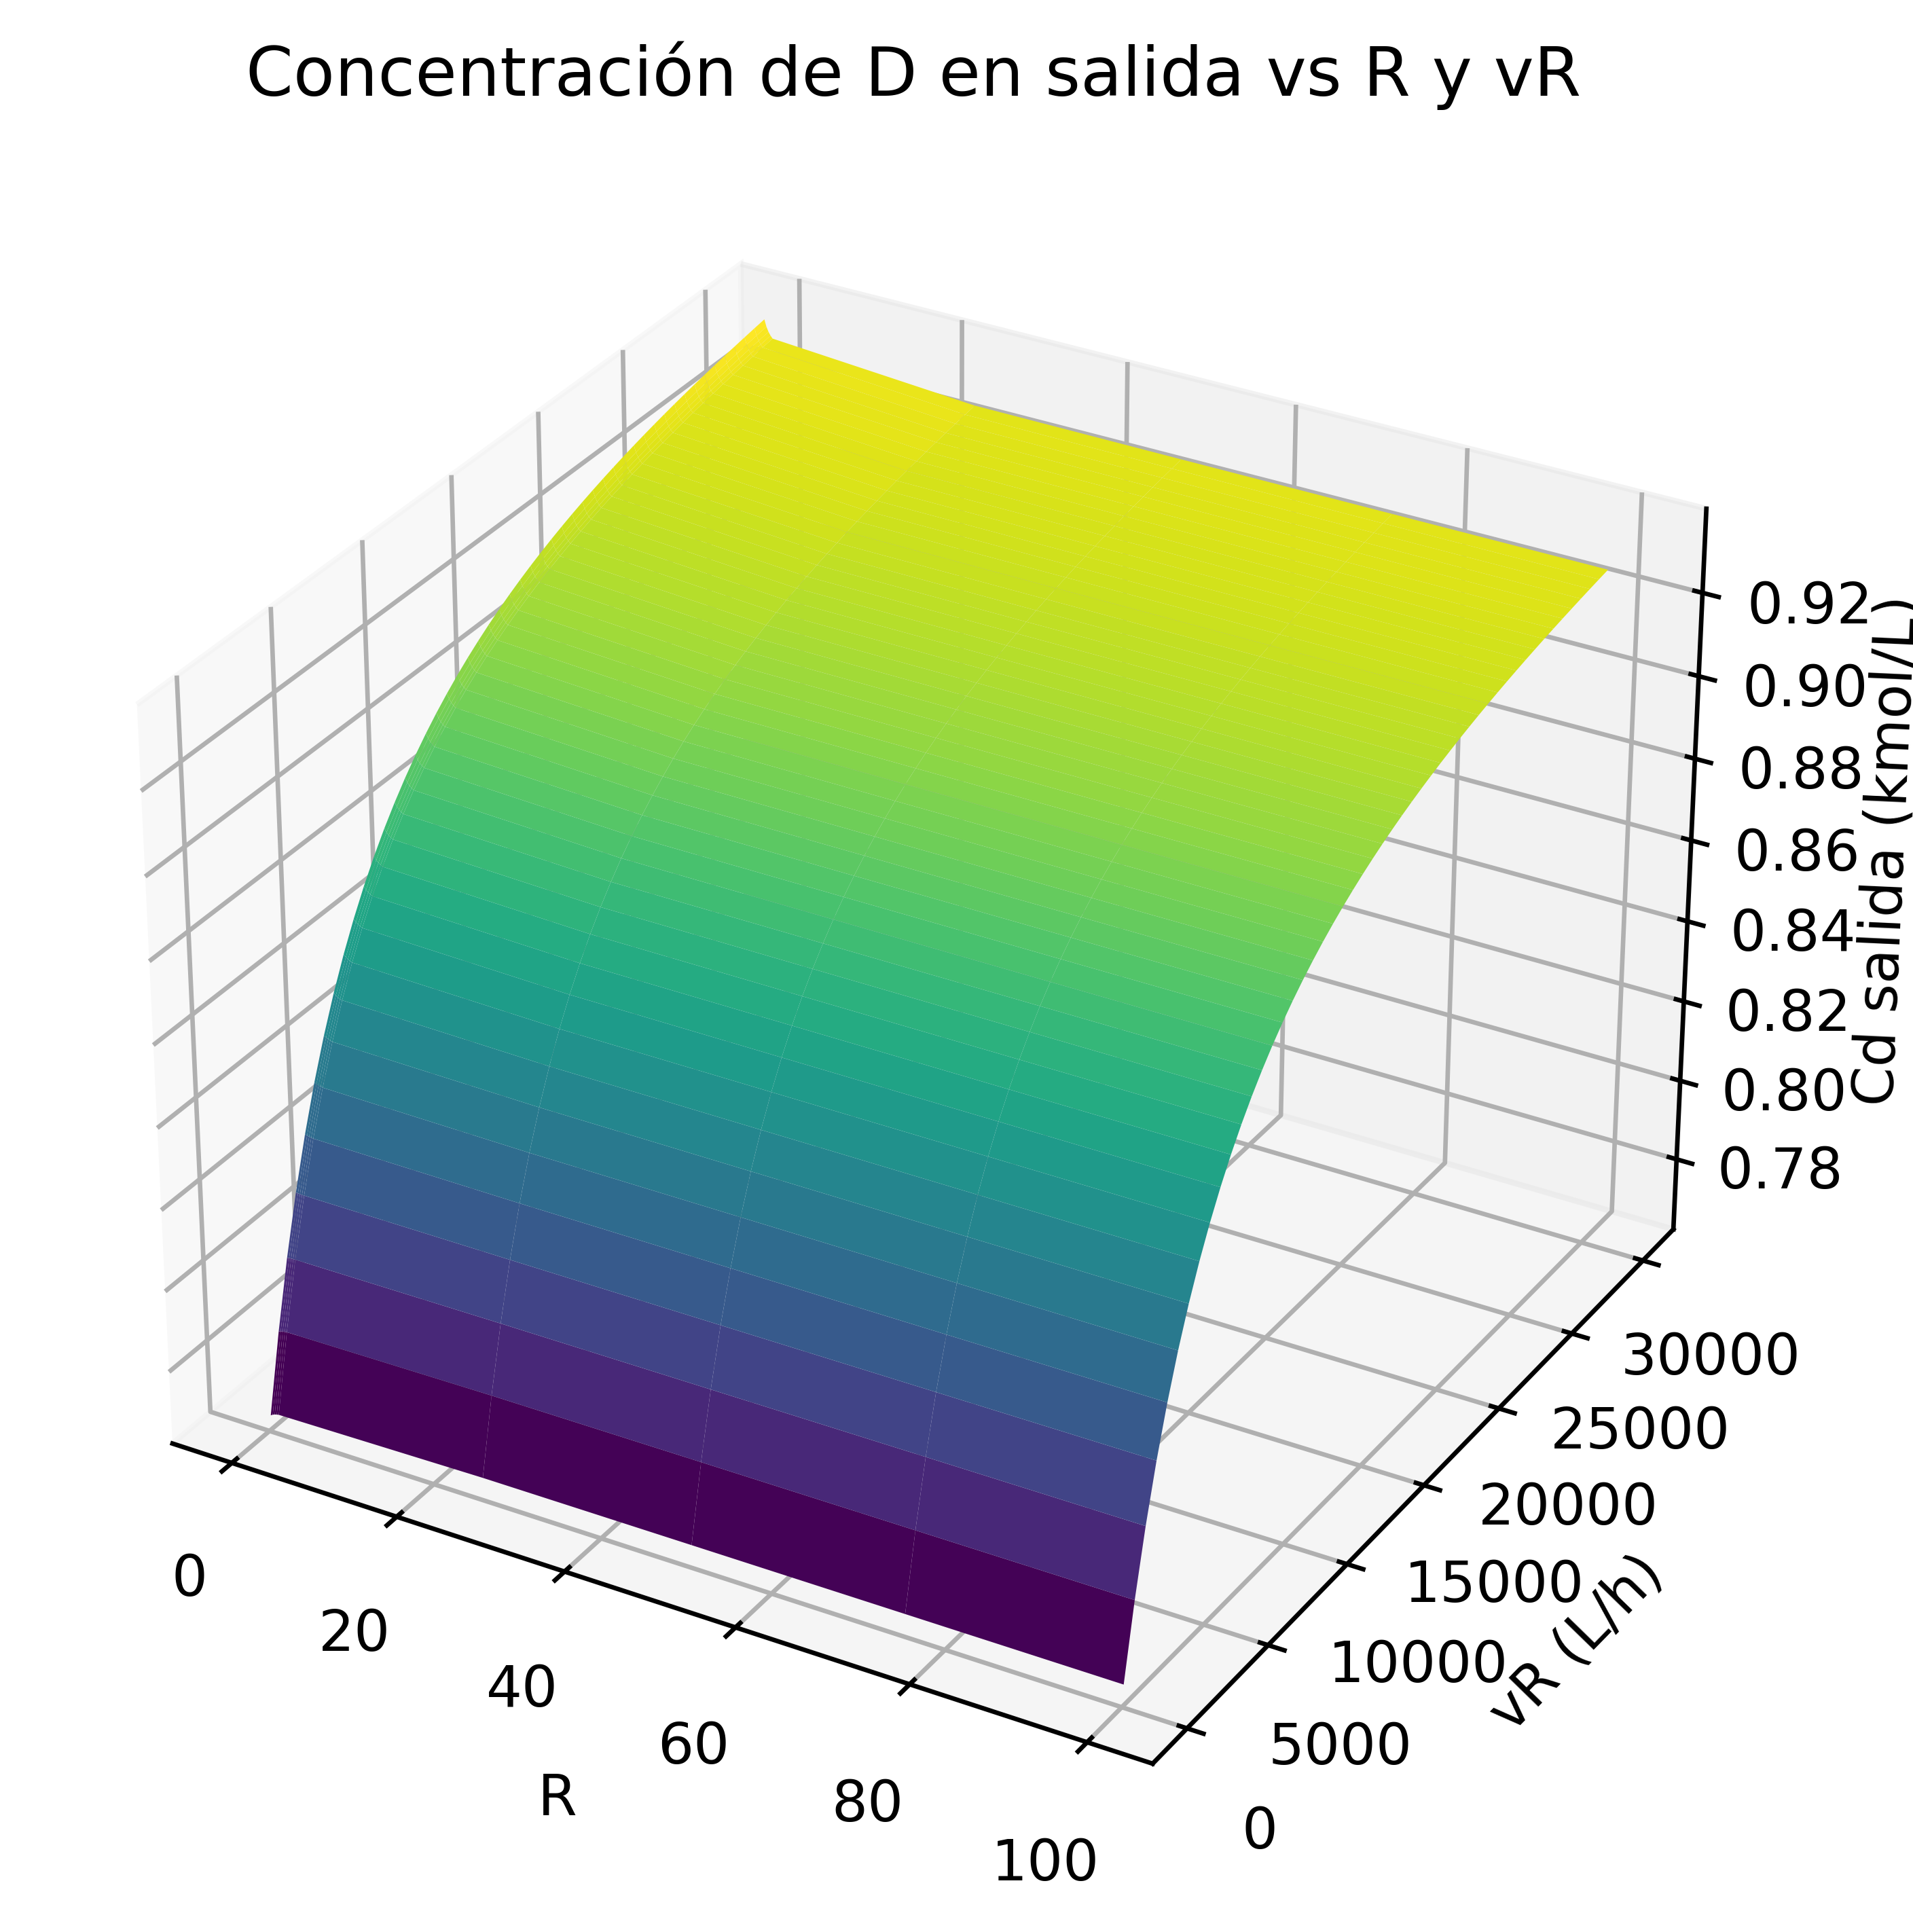

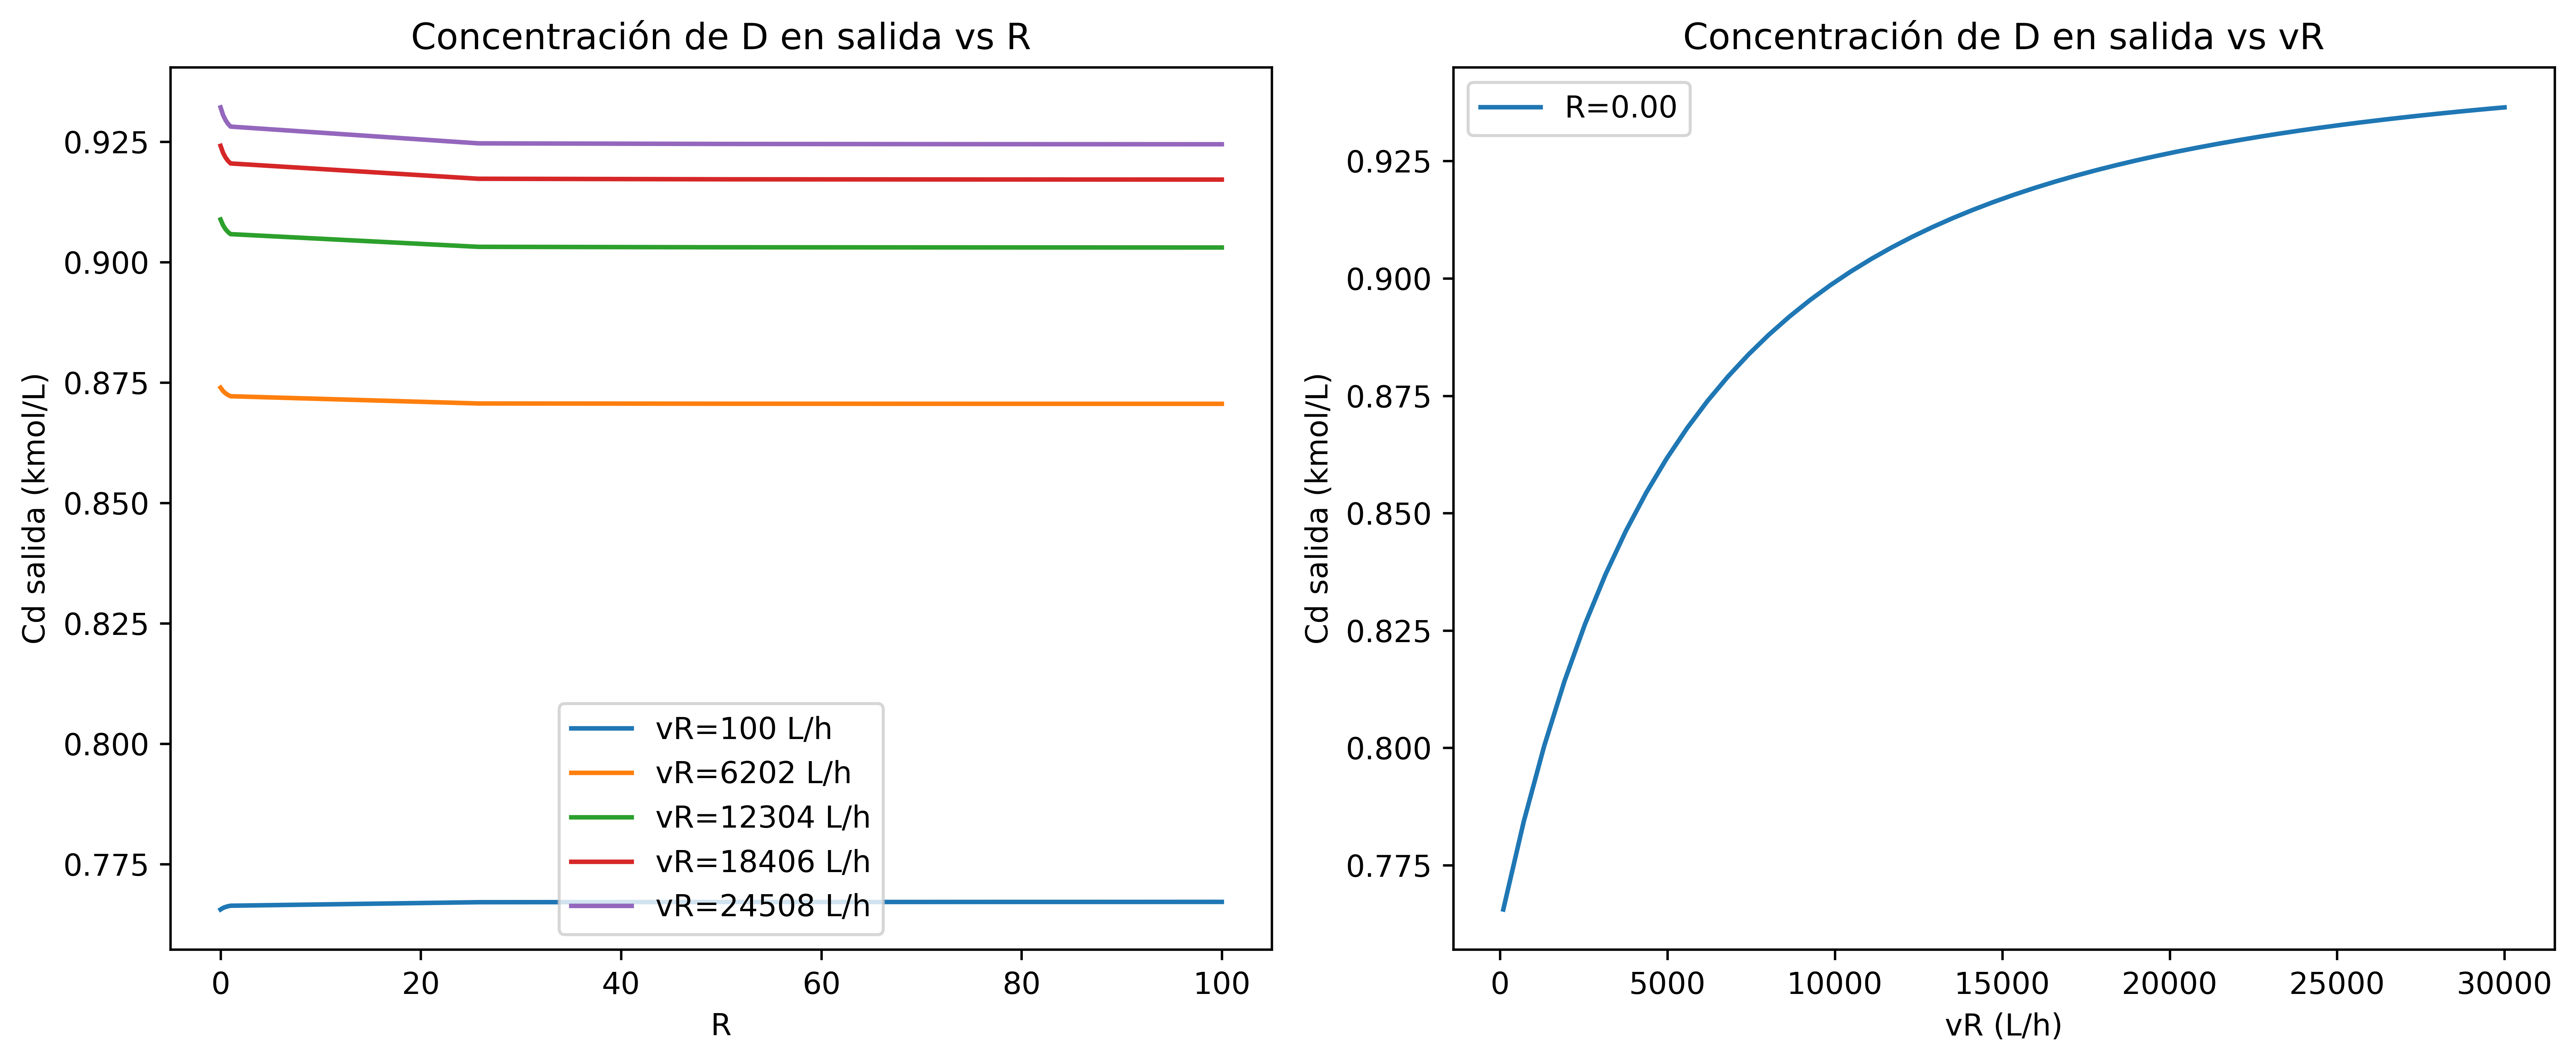

In [237]:
fig = plt.figure(dpi=600)
R_mesh, vR_mesh = np.meshgrid(R_vals, vR_vals)
Cd_mesh = np.zeros_like(R_mesh)
for i in range(R_mesh.shape[0]):    
    for j in range(R_mesh.shape[1]):
        R_val = R_mesh[i, j]
        vR_val = vR_mesh[i, j]
        Cd_mesh[i, j] = dict_results[(vR_val, R_val)][2] # concentracion D salida
ax3d = fig.add_subplot(111, projection='3d',
                        elev=30)
ax3d.plot_surface(R_mesh, vR_mesh, Cd_mesh, cmap='viridis')
ax3d.set_xlabel('R')
ax3d.set_ylabel('vR (L/h)')
ax3d.set_zlabel('Cd salida (kmol/L)')
ax3d.zaxis.labelpad=0.7
ax3d.set_title('Concentración de D en salida vs R y vR')
plt.tight_layout()


# plots 2D
fig2, ax2 = plt.subplots(1, 2, figsize=(12, 5), dpi=600)
# plot Cd vs R para varios vR 
for vR in vR_vals[::10]: # tomamos cada 10 
    Cd_vals = []
    for R in R_vals:
        Cd_vals.append(dict_results[(vR, R)][2])
    ax2[0].plot(R_vals, Cd_vals, label=f'vR={vR:.0f} L/h')
ax2[0].set_xlabel('R')
ax2[0].set_ylabel('Cd salida (kmol/L)')
ax2[0].set_title('Concentración de D en salida vs R')
ax2[0].legend()
# plot Cd vs vR para varios R
for R in R_vals[::10]: # tomamos cada 10
    Cd_vals = []
    for vR in vR_vals:
        Cd_vals.append(dict_results[(vR, R)][2])
    ax2[1].plot(vR_vals, Cd_vals, label=f'R={R:.2f}')
ax2[1].set_xlabel('vR (L/h)')
ax2[1].set_ylabel('Cd salida (kmol/L)')
ax2[1].set_title('Concentración de D en salida vs vR')
ax2[1].legend()
plt.tight_layout()


Utilizamos los valores de R = 0 y vR = 2*v0

In [238]:
def define_volumes(v0, vR2, R):
    v0 = v0
    v3 = v0 # estado estacionario
    vR1 = R * v3
    v1 = v0 + vR1
    v2 = (R+1) * v3
    vR2 = vR2
    v4 = v3 + vR2
    v5 = v4
    v6 = v0 # estado estacionario
    return v0, v1, v2, v3, vR1, v4, v5, v6, vR2


r = 0
vr = 2 * v0 #L/h
dict_results = {}
# solucion del pfr1 con reciclo
cR1 = np.zeros(5) # initial guess de reciclo del pfr1
converged_pfr1 = False
v0, v1, v2, v3, vR1, v4, v5, v6, vR2 = define_volumes(v0, vr, r) # volumenes definidos previamente
while not converged_pfr1:
    # punto de mezcla 0, 1, vR1
    
    CaR1, CbR1, CcR1, CdR1, CeR1 = cR1
    Ca1 = (Ca0 * v0 + CaR1 * vR1) / v1
    Cb1 = (Cb0 * v0 + CbR1 * vR1) / v1
    Cc1 = (Cc0 * v0 + CcR1 * vR1) / v1
    Cd1 = (Cd0 * v0 + CdR1 * vR1) / v1
    Ce1 = (Ce0 * v0 + CeR1 * vR1) / v1
    # balance PFR 1
    sol_pfr1 = solve_ivp(pfr_dV, [0, V1], [Ca1, Cb1, Cc1, Cd1, Ce1], args=(k1, k2, v1), method='LSODA')
    Ca2, Cb2, Cc2, Cd2, Ce2 = sol_pfr1.y[:, -1]
    # balance reciclo pfr1
    Ca3 = CaR1_new = Ca2 # recordemos que las concentraciones en 2, 3, y R1 son iguales
    Cb3 = CbR1_new = Cb2
    Cc3 = CcR1_new = Cc2
    Cd3 = CdR1_new = Cd2
    Ce3 = CeR1_new = Ce2
    # convergencia pfr1
    if np.allclose([CaR1_new, CbR1_new, CcR1_new, CdR1_new, CeR1_new], cR1, atol=1e-6):
        converged_pfr1 = True
    cR1 = [CaR1_new, CbR1_new, CcR1_new, CdR1_new, CeR1_new]
# despues de este while tenemos las concentraciones de 3
# solución del sistema B (ver pauta)
CaR2 = 0 # initial guess de reciclo del pfr2
converged_B = False # convergencia del sistema B
while not converged_B:
    # punto de mezcla 3, 4, y R2
    Ca4 = (Ca3 * v3 + CaR2 * vR2) / v4
    Cb4 = (Cb3 * v3 ) / v4
    Cc4 = (Cc3 * v3 ) / v4
    Cd4 = (Cd3 * v3 ) / v4
    Ce4 = (Ce3 * v3 ) / v4
    # balance PFR 2
    sol_pfr2 = solve_ivp(pfr_dV, [0, V2], [Ca4, Cb4, Cc4, Cd4, Ce4], args=(k1, k2, v4), method='LSODA')
    Ca5, Cb5, Cc5, Cd5, Ce5 = sol_pfr2.y[:, -1]
    # balance del separador de benceno
    CaR2_new = (Ca5 * v5) / vR2
    Cb6 = (Cb5 * v5) / v6
    Cc6 = (Cc5 * v5) / v6
    Cd6 = (Cd5 * v5) / v6
    Ce6 = (Ce5 * v5) / v6
    # convergencia sistema B
    if abs(CaR2_new - CaR2) < 1e-6:
        converged_B = True
    CaR2 = CaR2_new
dict_results[(vr, r)] = (Cb6, Cc6, Cd6, Ce6) # guardamos los resultados una vez convergidos
    

In [239]:
# valores

print(f'Concentración de salida B: {Cb6:.4f} kmol/L')
print(f'Concentración de salida C: {Cc6:.4f} kmol/L')
print(f'Concentración de salida D: {Cd6:.4f} kmol/L')
print(f'Concentración de salida E: {Ce6:.4f} kmol/L')

# selectividad global del de monoclorobenceno sobre diclorobenceno
S = Cd6 / Ce6
print(f'Selectividad global de monoclorobenceno sobre diclorobenceno: {S:.4f}')

Concentración de salida B: 3.9267 kmol/L
Concentración de salida C: 1.0733 kmol/L
Concentración de salida D: 0.9267 kmol/L
Concentración de salida E: 0.0733 kmol/L
Selectividad global de monoclorobenceno sobre diclorobenceno: 12.6381


# BONUS

## B

In [240]:

def pfr_dV(t, x, k1, k2, v):
    '''
    Define el sistema de ecuciones diferenciales para el reactor de flujo pistón (PFR).
    Este toma la forma 
    dF/dV = r
    donde F es el vector de flujos molares y r es el vector de velocidades de reacción.
    ---
    Reference:
    Fogler, H. S. (2016). Elements of chemical reaction engineering (Fifth edition). Prentice-Hall, Pearson.
    Pagina 16.
    
    '''
    Ca, Cb, Cc, Cd, Ce = x
    dCa_dV = 1/v * (-k1 * Ca * Cb)
    dCb_dV = 1/v * (-k1 * Ca * Cb - k2 * Cb * Cd)
    dCc_dV = 1/v * (k1 * Ca * Cb + k2 * Cb * Cd)
    dCd_dV = 1/v * (k1 * Ca * Cb - k2 * Cb * Cd)
    dCe_dV = 1/v * (k2 * Cb * Cd)
    return [dCa_dV, dCb_dV, dCc_dV, dCd_dV, dCe_dV]

# definimos los valores que conocemos
# constantes de velocidad
k1 = 0.412 # L/kmol h
k2 = 0.055 # L/kmol h
# concentraciones del flujo de entrada
Ca0 = 1 # kmol / L
Cb0 = 5 # kmol / L
Cc0 = 0 # kmol / L
Cd0 = 0 # kmol / L
Ce0 = 0 # kmol / L
# valor del flujo de entrada
v0 = 10 # m^3/h
# ahora escalamos para que v0 quede en unidades de L/h
v0 = v0 * 1000 # L/h
# tamaño de reactores
V1 = 5.56 # m^3
V2 = 11.607 # m^3
# ahora escalamos para que V1 y V2 queden en unidades de L
V1 = V1 * 1000 # L
V2 = V2 * 1000 # L

Es posible notar que se pueden pre-calcular las corrientes del proceso, lo que permite simplificar la resolución, especialmente en los casos del bonús que son más complejos.

In [241]:
def define_volumes(v0, vR2, R):
    v0 = v0
    vR2 = vR2
    v1 = v0 + vR2
    v4 = v1 # ESTO TAMBIEN LO CAMBIE
    v3 = (R+1) * v4
    vR1 = R * v4
    v2 = v1 + vR1
    v5 = v4 
    v6 = v0 
    return v0, v1, v2, v3, v4, v5, v6, vR1, vR2

R_vals = np.concatenate((np.linspace(0, 1, 5),np.linspace(1, 100, 5))) # sacamos varios entre 0 hasta 1 y 1 hasta 100
vR_vals = np.linspace(100, v0*3, 5)
dict_results = {}
for R in R_vals:
    for vR2 in vR_vals:
        v0, v1, v2, v3, v4, v5, v6, vR1, vR2 = define_volumes(v0, vR2, R)
        converged = False
        # initial guess de CaR2
        CaR2 = 0
        while not converged:
            # empezamos a resolver el sistema
            # balance de masa punto de mezcla 0, R2, 1
            Ca1 = (Ca0 * v0 + CaR2 * vR2) / v1
            Cb1 = (Cb0 * v0 ) / v1
            # balance del pfr1 con reciclo R1
            
            pfr1_convergence = False
            # initial guess concentraciones de reciclo del pfr
            c_R1 = np.zeros(5)
            while not pfr1_convergence:
                Ca2 = (Ca1 * v1 + c_R1[0] * vR1) / v2
                Cb2 = (Cb1 * v1 + c_R1[1] * vR1) / v2
                Cc2 = (c_R1[2] * vR1) / v2
                Cd2 = (c_R1[3] * vR1) / v2
                Ce2 = (c_R1[4] * vR1) / v2
                c2 = [Ca2, Cb2, Cc2, Cd2, Ce2]
                # resolvemos el sistema de ODEs para el PFR 1
                sol1 = solve_ivp(fun=pfr_dV,
                                t_span = (0, V1), # recordar que t_span es la variable independiente en este caso el volumen
                                y0 = c2, # condicion inicial
                                args = (k1, k2, v2), # parametros
                )
                Ca3, Cb3, Cc3, Cd3, Ce3 = sol1.y[:,-1] # extraemos las concentraciones en la salida del PFR
                # recordemos que las concentraciones en el reciclo son las mismas en las 3 corrientes
                Ca4 = CaR1 = Ca3
                Cb4 = CbR1 = Cb3
                Cc4 = CcR1 = Cc3
                Cd4 = CdR1 = Cd3
                Ce4 = CeR1 = Ce3
                # verificamos convergencia
                c_R1_new = [CaR1, CbR1, CcR1, CdR1, CeR1]
                if np.allclose(c_R1, c_R1_new, atol=1e-10):
                    pfr1_convergence = True
                c_R1 = c_R1_new.copy()
            # despues del ciclo anterior deberímos obtener las concentraciones en la corriente 4
            # balance del pfr2
            sol2 = solve_ivp(fun=pfr_dV,
                            t_span = (0, V2), # recordar que t_span es la variable independiente en este caso el volumen
                            y0 = [Ca4, Cb4, Cc4, Cd4, Ce4], # condicion inicial
                            args = (k1, k2, v4), # parametros
            )
            
            Ca5, Cb5, Cc5, Cd5, Ce5 = sol2.y[:,-1] # extraemos las concentraciones en la salida del PFR
            # balance del separador de benceno
            CaR2_new = (Ca5 * v5) / vR2 # new porque se comparar
            Cb6 = (Cb5 * v5) / v6
            Cc6 = (Cc5 * v5) / v6
            Cd6 = (Cd5 * v5) / v6
            Ce6 = (Ce5 * v5) / v6
            if abs(CaR2_new - CaR2) < 1e-6:
                converged = True
                
            CaR2 = CaR2_new
        dict_results[(R, vR2)] = [Cb6, Cc6, Cd6, Ce6] # guardamos fuera del while
        




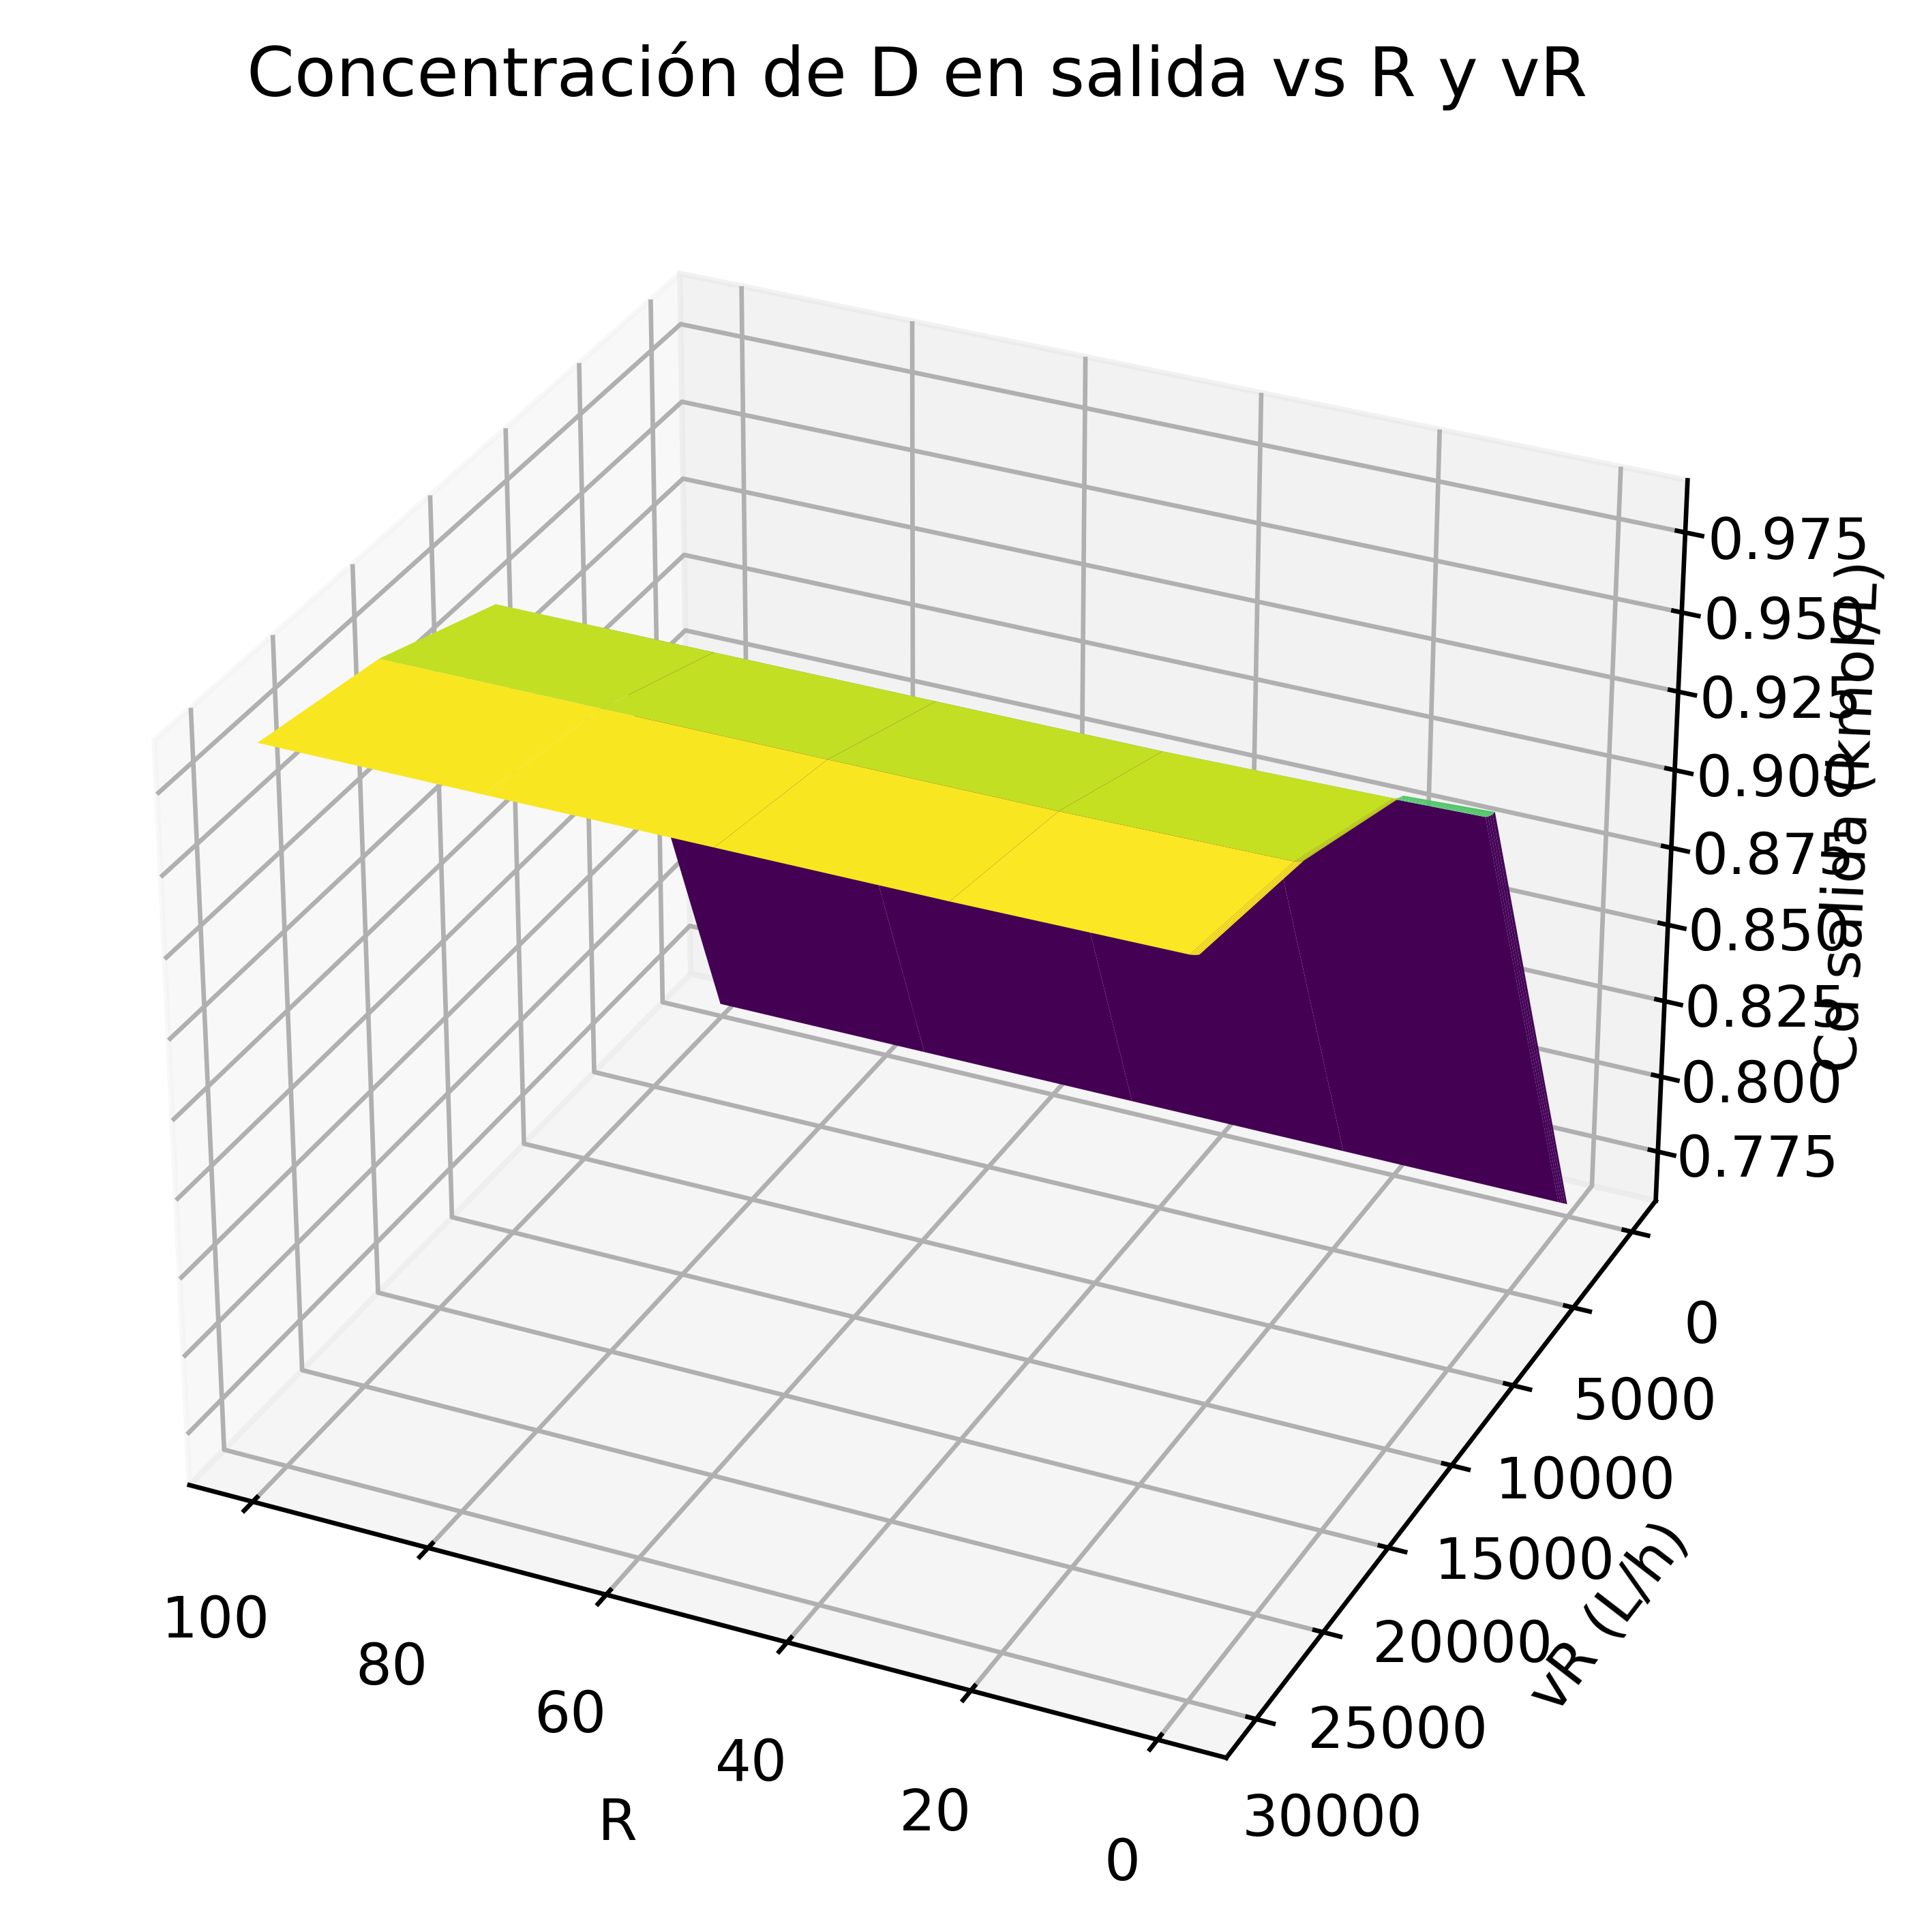

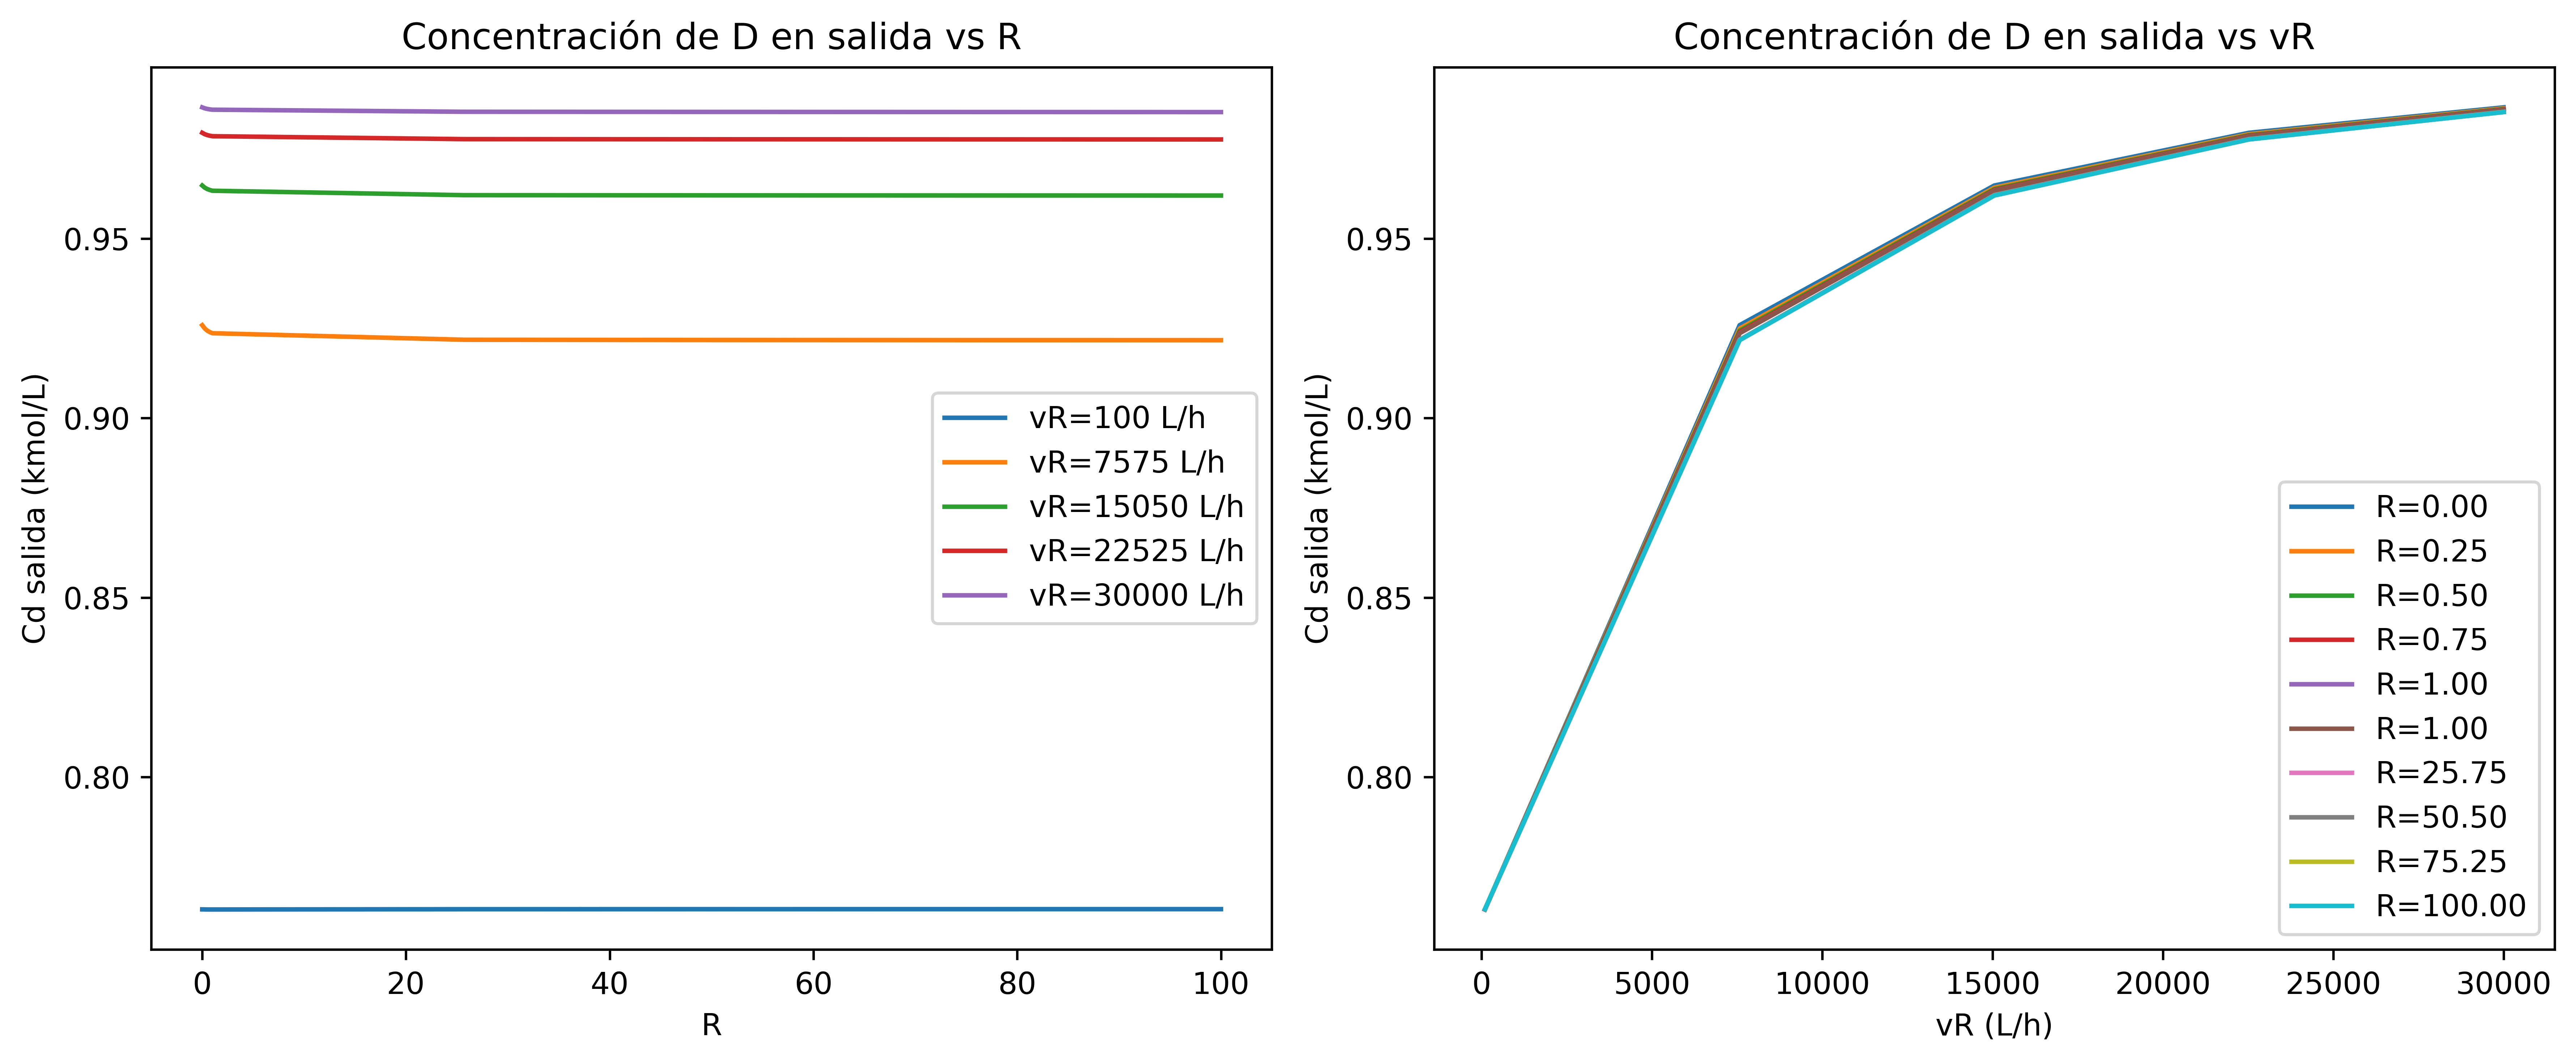

In [242]:
fig = plt.figure(dpi=600)
R_mesh, vR_mesh = np.meshgrid(R_vals, vR_vals)
Cd_mesh = np.zeros_like(R_mesh)
for i in range(R_mesh.shape[0]):    
    for j in range(R_mesh.shape[1]):
        R_val = R_mesh[i, j]
        vR_val = vR_mesh[i, j]
        Cd_mesh[i, j] = dict_results[(R_val, vR_val)][2] # concentracion D salida
ax3d = fig.add_subplot(111, projection='3d',
                        azim=115)
ax3d.plot_surface(R_mesh, vR_mesh, Cd_mesh, cmap='viridis')
ax3d.set_xlabel('R')
ax3d.set_ylabel('vR (L/h)')
ax3d.set_zlabel('Cd salida (kmol/L)')
ax3d.zaxis.labelpad=-0.7
ax3d.set_title('Concentración de D en salida vs R y vR')
plt.tight_layout()


# plots 2D
fig2, ax2 = plt.subplots(1, 2, figsize=(12, 5), dpi=600)
# plot Cd vs R para varios vR 
for vR in vR_vals: # tomamos cada 10 
    Cd_vals = []
    for R in R_vals:
        Cd_vals.append(dict_results[(R, vR)][2])
    ax2[0].plot(R_vals, Cd_vals, label=f'vR={vR:.0f} L/h')
ax2[0].set_xlabel('R')
ax2[0].set_ylabel('Cd salida (kmol/L)')
ax2[0].set_title('Concentración de D en salida vs R')
ax2[0].legend()
# plot Cd vs vR para varios R
for R in R_vals: # tomamos cada 10
    Cd_vals = []
    for vR in vR_vals:
        Cd_vals.append(dict_results[(R, vR)][2])
    ax2[1].plot(vR_vals, Cd_vals, label=f'R={R:.2f}')
ax2[1].set_xlabel('vR (L/h)')
ax2[1].set_ylabel('Cd salida (kmol/L)')
ax2[1].set_title('Concentración de D en salida vs vR')
ax2[1].legend()
plt.tight_layout()


In [243]:
def define_volumes(v0, vR2, R):
    v0 = v0
    vR2 = vR2
    v1 = v0 + vR2
    v4 = v1 # ESTO LO CAMBIE RESPECTO A GITHUB Y LA PAUTA
    v3 = (R+1) * v4
    vR1 = R * v4
    v2 = v1 + vR1
    v5 = v4 
    v6 = v0 
    return v0, v1, v2, v3, v4, v5, v6, vR1, vR2

R = 1e-10
vR2 = 2*v0 # ESTO LO CAMBIE RESPECTO A GITHUB Y LA PAUTA

v0, v1, v2, v3, v4, v5, v6, vR1, vR2 = define_volumes(v0, vR2, R)
converged = False
# initial guess de CaR2
CaR2 = 0
while not converged:
    # empezamos a resolver el sistema
    # balance de masa punto de mezcla 0, R2, 1
    Ca1 = (Ca0 * v0 + CaR2 * vR2) / v1
    Cb1 = (Cb0 * v0 ) / v1
    # balance del pfr1 con reciclo R1
    
    pfr1_convergence = False
    # initial guess concentraciones de reciclo del pfr
    c_R1 = np.zeros(5)
    while not pfr1_convergence:
        Ca2 = (Ca1 * v1 + c_R1[0] * vR1) / v2
        Cb2 = (Cb1 * v1 + c_R1[1] * vR1) / v2
        Cc2 = (c_R1[2] * vR1) / v2
        Cd2 = (c_R1[3] * vR1) / v2
        Ce2 = (c_R1[4] * vR1) / v2
        c2 = [Ca2, Cb2, Cc2, Cd2, Ce2]
        # resolvemos el sistema de ODEs para el PFR 1
        sol1 = solve_ivp(fun=pfr_dV,
                        t_span = (0, V1), # recordar que t_span es la variable independiente en este caso el volumen
                        y0 = c2, # condicion inicial
                        args = (k1, k2, v2), # parametros
        )
        Ca3, Cb3, Cc3, Cd3, Ce3 = sol1.y[:,-1] # extraemos las concentraciones en la salida del PFR
        # recordemos que las concentraciones en el reciclo son las mismas en las 3 corrientes
        Ca4 = CaR1 = Ca3
        Cb4 = CbR1 = Cb3
        Cc4 = CcR1 = Cc3
        Cd4 = CdR1 = Cd3
        Ce4 = CeR1 = Ce3
        # verificamos convergencia
        c_R1_new = [CaR1, CbR1, CcR1, CdR1, CeR1]
        if np.allclose(c_R1, c_R1_new, atol=1e-10):
            pfr1_convergence = True
        c_R1 = c_R1_new.copy()
    # despues del ciclo anterior deberímos obtener las concentraciones en la corriente 4
    # balance del pfr2
    sol2 = solve_ivp(fun=pfr_dV,
                    t_span = (0, V2), # recordar que t_span es la variable independiente en este caso el volumen
                    y0 = [Ca4, Cb4, Cc4, Cd4, Ce4], # condicion inicial
                    args = (k1, k2, v4), # parametros
    )
    
    Ca5, Cb5, Cc5, Cd5, Ce5 = sol2.y[:,-1] # extraemos las concentraciones en la salida del PFR
    # balance del separador de benceno
    CaR2_new = (Ca5 * v5) / vR2 # new porque se comparar
    Cb6 = (Cb5 * v5) / v6
    Cc6 = (Cc5 * v5) / v6
    Cd6 = (Cd5 * v5) / v6
    Ce6 = (Ce5 * v5) / v6
    if abs(CaR2_new - CaR2) < 1e-6:
        converged = True
        
    CaR2 = CaR2_new
dict_results[(R, vR2)] = [Cb6, Cc6, Cd6, Ce6] # guardamos fuera del while



In [244]:
# valores

print(f'Concentración de salida B: {Cb6:.4f} kmol/L')
print(f'Concentración de salida C: {Cc6:.4f} kmol/L')
print(f'Concentración de salida D: {Cd6:.4f} kmol/L')
print(f'Concentración de salida E: {Ce6:.4f} kmol/L')

# selectividad global del de monoclorobenceno sobre diclorobenceno
S = Cd6 / Ce6
print(f'Selectividad global de monoclorobenceno sobre diclorobenceno: {S:.4f}')

Concentración de salida B: 3.9757 kmol/L
Concentración de salida C: 1.0243 kmol/L
Concentración de salida D: 0.9757 kmol/L
Concentración de salida E: 0.0243 kmol/L
Selectividad global de monoclorobenceno sobre diclorobenceno: 40.2024


## D

In [245]:
def pfr_dV(t, x, k1, k2, v):
    '''
    Define el sistema de ecuciones diferenciales para el reactor de flujo pistón (PFR).
    Este toma la forma 
    dF/dV = r
    donde F es el vector de flujos molares y r es el vector de velocidades de reacción.
    ---
    Reference:
    Fogler, H. S. (2016). Elements of chemical reaction engineering (Fifth edition). Prentice-Hall, Pearson.
    Pagina 16.
    
    '''
    Ca, Cb, Cc, Cd, Ce = x
    dCa_dV = 1/v * (-k1 * Ca * Cb)
    dCb_dV = 1/v * (-k1 * Ca * Cb - k2 * Cb * Cd)
    dCc_dV = 1/v * (k1 * Ca * Cb + k2 * Cb * Cd)
    dCd_dV = 1/v * (k1 * Ca * Cb - k2 * Cb * Cd)
    dCe_dV = 1/v * (k2 * Cb * Cd)
    return [dCa_dV, dCb_dV, dCc_dV, dCd_dV, dCe_dV]
# definimos los valores que conocemos
# constantes de velocidad
k1 = 0.412 # L/kmol h
k2 = 0.055 # L/kmol h
# concentraciones del flujo de entrada
Ca0 = 1 # kmol / L
Cb0 = 5 # kmol / L
Cc0 = 0 # kmol / L
Cd0 = 0 # kmol / L
Ce0 = 0 # kmol / L
# valor del flujo de entrada
v0 = 10 # m^3/h
# ahora escalamos para que v0 quede en unidades de L/h
v0 = v0 * 1000 # L/h
# tamaño de reactores
V1 = 5.56 # m^3
V2 = 11.607 # m^3
# ahora escalamos para que V1 y V2 queden en unidades de L
V1 = V1 * 1000 # L
V2 = V2 * 1000 # L
# definimos un R 

Al igual que antes definimos una solución para los flujos del sistema

In [246]:
dict_results = {}
def define_volumes(v0, vR3, R1, R2):
    v1 = v0 + vR3
    v4 = v1
    v3 = (R1 + 1) * v4
    vR1 = R1 * v4
    v2 = v1 + vR1
    v7 = v4
    v6 = (R2 + 1) * v7
    vR2 = R2 * v7
    v5 = v4 + vR2
    v8 = v0 
    return v0, v1, v2, v3, v4, v5, v6, v7, v8, vR1, vR2, vR3
R1_vals  = np.linspace(0, 3.0, 5)
R2_vals  = np.linspace(0, 2.0, 5)
vR3_vals = np.linspace(1000, v0*2, 5)
for R1 in R1_vals:
    for R2 in R2_vals:
        for vR3 in vR3_vals:
            v0, v1, v2, v3, v4, v5, v6, v7, v8, vR1, vR2, vR3 = define_volumes(v0, vR3, R1, R2)
            converged = False
            CaR3 = 0.0   # guess inicial de CaR3
            while not converged:
                # Balance de masa en el punto de mezcla
                Ca1 = (Ca0 * v0 + CaR3 * vR3) / v1
                Cb1 = (Cb0 * v0) / v1
                Cc1 = 0.0
                Cd1 = 0.0
                Ce1 = 0.0
                pfr1_convergence = False
                c_R1 = np.zeros(5)
                # El siguiente ciclo resuelve el primer PFR
                while not pfr1_convergence:
                    Ca2 = (Ca1 * v1 + c_R1[0] * vR1) / v2
                    Cb2 = (Cb1 * v1 + c_R1[1] * vR1) / v2
                    Cc2 = (c_R1[2] * vR1) / v2
                    Cd2 = (c_R1[3] * vR1) / v2
                    Ce2 = (c_R1[4] * vR1) / v2
                    c2  = [Ca2, Cb2, Cc2, Cd2, Ce2]
                    sol1 = solve_ivp(pfr_dV, (0, V1), c2, args=(k1, k2, v2))
                    Ca3, Cb3, Cc3, Cd3, Ce3 = sol1.y[:, -1]
                    c_R1_new = [Ca3, Cb3, Cc3, Cd3, Ce3]
                    if np.allclose(c_R1, c_R1_new, atol=1e-8):
                        pfr1_convergence = True
                    c_R1 = c_R1_new
                Ca4, Cb4, Cc4, Cd4, Ce4 = c_R1
                pfr2_convergence = False
                c_R2 = np.zeros(5)
                # Este ciclo resuelve el segundo PFR
                while not pfr2_convergence:
                    Ca5 = (Ca4 * v4 + c_R2[0] * vR2) / v5
                    Cb5 = (Cb4 * v4 + c_R2[1] * vR2) / v5
                    Cc5 = (Cc4 * v4 + c_R2[2] * vR2) / v5
                    Cd5 = (Cd4 * v4 + c_R2[3] * vR2) / v5
                    Ce5 = (Ce4 * v4 + c_R2[4] * vR2) / v5
                    c5  = [Ca5, Cb5, Cc5, Cd5, Ce5]
                    sol2 = solve_ivp(pfr_dV, (0, V2), c5, args=(k1, k2, v5))
                    Ca6, Cb6, Cc6, Cd6, Ce6 = sol2.y[:, -1]
                    c_R2_new = [Ca6, Cb6, Cc6, Cd6, Ce6]
                    if np.allclose(c_R2, c_R2_new, atol=1e-8):
                        pfr2_convergence = True
                    c_R2 = c_R2_new
                Ca7, Cb7, Cc7, Cd7, Ce7 = c_R2 
                CaR3_new = (v7 / vR3) * Ca7
                Cb8 = (v7 / v8) * Cb7
                Cc8 = (v7 / v8) * Cc7
                Cd8 = (v7 / v8) * Cd7
                Ce8 = (v7 / v8) * Ce7
                CaR3_old = CaR3
                CaR3 = CaR3_new
                if abs(CaR3 - CaR3_old) < 1e-6:
                    converged = True
            dict_results[(R1, R2, vR3)] = [Cb8, Cc8, Cd8, Ce8]

In [247]:
print(f'Concentración de salida B: {dict_results[(0,0,2*v0)][0]:.4f} kmol/L')
print(f'Concentración de salida C: {dict_results[(0,0,2*v0)][1]:.4f} kmol/L')
print(f'Concentración de salida D: {dict_results[(0,0,2*v0)][2]:.4f} kmol/L')
print(f'Concentración de salida E: {dict_results[(0,0,2*v0)][3]:.4f} kmol/L')
# selectividad global del de monoclorobenceno sobre diclorobenceno
S = dict_results[(0,0,2*v0)][2] / dict_results[(0,0,2*v0)][3]
print(f'Selectividad global de monoclorobenceno sobre diclorobenceno: {S:.4f}')

Concentración de salida B: 3.9757 kmol/L
Concentración de salida C: 1.0243 kmol/L
Concentración de salida D: 0.9757 kmol/L
Concentración de salida E: 0.0243 kmol/L
Selectividad global de monoclorobenceno sobre diclorobenceno: 40.2024


In [248]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.patches import Patch

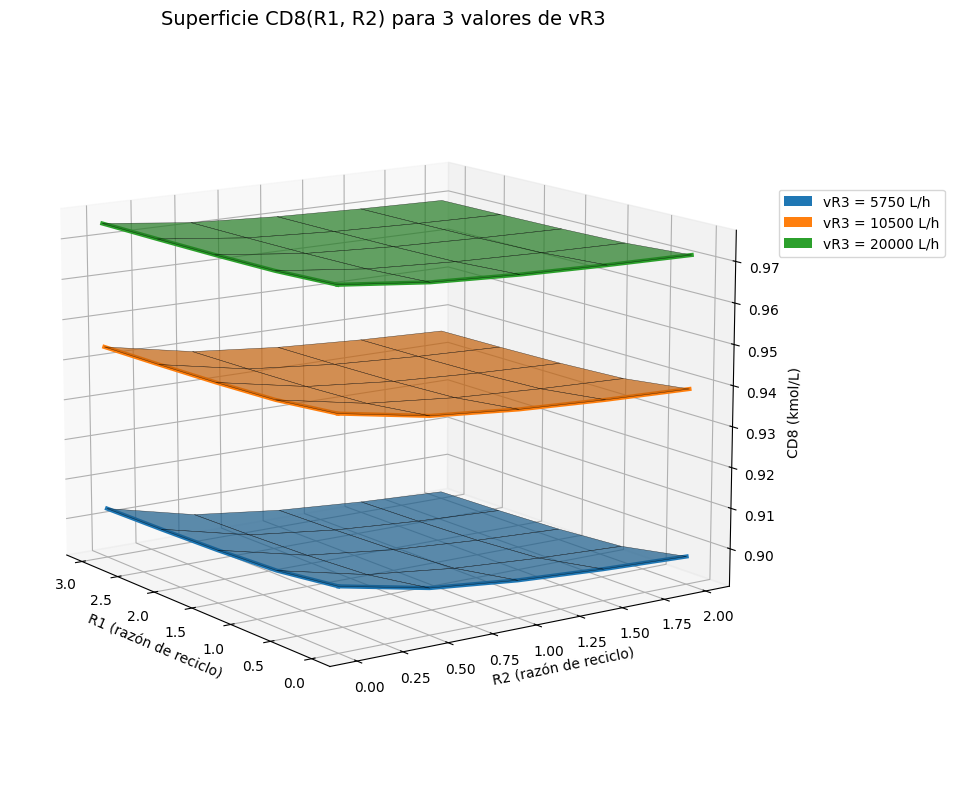

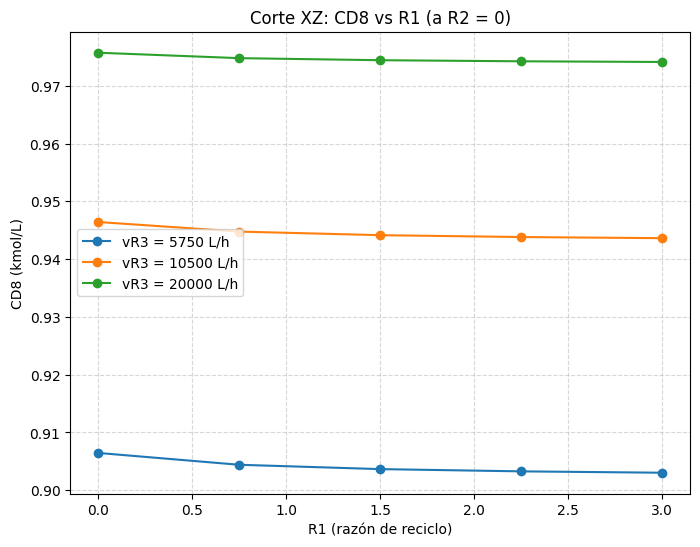

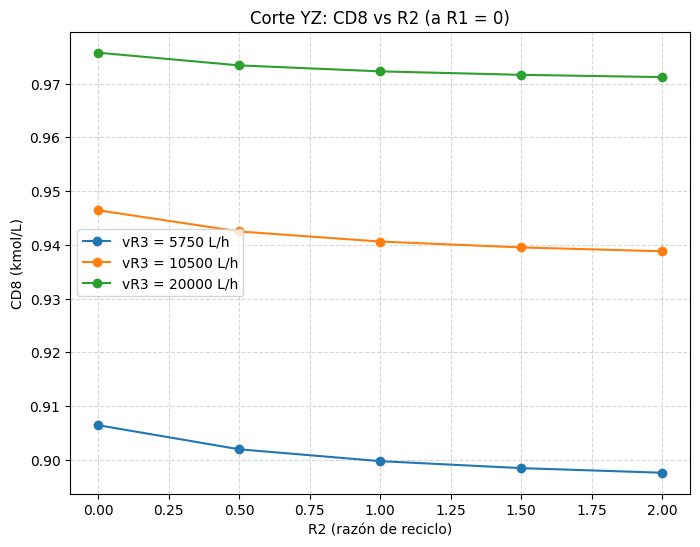

In [249]:
vR3_low  = vR3_vals[1]
vR3_mid  = vR3_vals[len(vR3_vals)//2]
vR3_high = vR3_vals[-1]
vR3_selected = [vR3_low, vR3_mid, vR3_high]
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
R1_grid, R2_grid = np.meshgrid(R1_vals, R2_vals)
legend_elements = []
for i, vR3 in enumerate(vR3_selected):
    Z = np.zeros_like(R1_grid)
    for idx_r1, R1 in enumerate(R1_vals):
        for idx_r2, R2 in enumerate(R2_vals):
            key = (R1, R2, vR3)
            Z[idx_r2, idx_r1] = dict_results[key][2] if key in dict_results else np.nan
    ax.plot_surface(
        R1_grid, R2_grid, Z,
        color=colors[i],
        alpha=0.7,
        edgecolor='k',
        linewidth=0.3
    )
    ax.plot(R1_vals*0, R2_vals, Z[:,0], color=colors[i], linewidth=3)
    ax.plot(R1_vals, R2_vals*0, Z[0,:], color=colors[i], linewidth=3)
    legend_elements.append(
        Patch(facecolor=colors[i], label=f"vR3 = {vR3:.0f} L/h")
    )
ax.set_xlabel("R1 (razón de reciclo)")
ax.set_ylabel("R2 (razón de reciclo)")
ax.set_zlabel("CD8 (kmol/L)")
ax.set_title("Superficie CD8(R1, R2) para 3 valores de vR3", fontsize=14)
ax.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(1.02, 0.8))
ax.view_init(elev=25-12, azim=-35)
ax.invert_xaxis()
plt.tight_layout()
plt.show()
plt.figure(figsize=(8,6))
for i, vR3 in enumerate(vR3_selected):
    CD8_x = []
    for R1 in R1_vals:
        key = (R1, 0.0, vR3)
        CD8_x.append(dict_results[key][2])
    plt.plot(R1_vals, CD8_x, marker='o', label=f"vR3 = {vR3:.0f} L/h")
plt.xlabel("R1 (razón de reciclo)")
plt.ylabel("CD8 (kmol/L)")
plt.title("Corte XZ: CD8 vs R1 (a R2 = 0)")
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.show()
plt.figure(figsize=(8,6))
for i, vR3 in enumerate(vR3_selected):
    CD8_y = []
    for R2 in R2_vals:
        key = (0.0, R2, vR3)
        CD8_y.append(dict_results[key][2])
    
    plt.plot(R2_vals, CD8_y, marker='o', label=f"vR3 = {vR3:.0f} L/h")
plt.xlabel("R2 (razón de reciclo)")
plt.ylabel("CD8 (kmol/L)")
plt.title("Corte YZ: CD8 vs R2 (a R1 = 0)")
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.show()


## E

In [250]:
def pfr_dV(t, x, k1, k2, v):
    '''
    Define el sistema de ecuciones diferenciales para el reactor de flujo pistón (PFR).
    Este toma la forma 
    dF/dV = r
    donde F es el vector de flujos molares y r es el vector de velocidades de reacción.
    ---
    Reference:
    Fogler, H. S. (2016). Elements of chemical reaction engineering (Fifth edition). Prentice-Hall, Pearson.
    Pagina 16.
    
    '''
    Ca, Cb, Cc, Cd, Ce = x
    dCa_dV = 1/v * (-k1 * Ca * Cb)
    dCb_dV = 1/v * (-k1 * Ca * Cb - k2 * Cb * Cd)
    dCc_dV = 1/v * (k1 * Ca * Cb + k2 * Cb * Cd)
    dCd_dV = 1/v * (k1 * Ca * Cb - k2 * Cb * Cd)
    dCe_dV = 1/v * (k2 * Cb * Cd)
    return [dCa_dV, dCb_dV, dCc_dV, dCd_dV, dCe_dV]

# definimos los valores que conocemos
# constantes de velocidad
k1 = 0.412 # L/kmol h
k2 = 0.055 # L/kmol h
# concentraciones del flujo de entrada
Ca0 = 1 # kmol / L
Cb0 = 5 # kmol / L
Cc0 = 0 # kmol / L
Cd0 = 0 # kmol / L
Ce0 = 0 # kmol / L
# valor del flujo de entrada
v0 = 10 # m^3/h
# ahora escalamos para que v0 quede en unidades de L/h
v0 = v0 * 1000 # L/h
# tamaño de reactores
V1 = 5.56 # m^3
V2 = 11.607 # m^3
# ahora escalamos para que V1 y V2 queden en unidades de L
V1 = V1 * 1000 # L
V2 = V2 * 1000 # L

Al igual que antes definimos una solución para los flujos del sistema

In [251]:
vR1_vals = np.linspace(0, 2*v0, 7)   
R2_vals  = np.linspace(0, 10, 7)     
vR3_vals = np.linspace(0, 2*v0, 7)   
dict_results = {}
def define_volumes_e(v0, vR1, R2, vR3):
    """
    v0  : caudal de alimentación fresca (L/h)
    vR1 : caudal de reciclo de benceno puro (L/h)
    R2  : razón de reciclo interno después de PFR1 (adimensional)
    vR3 : caudal de reciclo de la corriente 6 (L/h)
    """
    v1 = v0 + vR3
    v2 = v1 + vR1
    v5 = v2
    vR2 = R2 * v5     
    v3  = v2 + vR2          
    v4  = v3                
    v6 = v5
    v7 = v6 - vR3      
    v8 = v7 - vR1        
    return v1, v2, v3, v4, v5, v6, v7, v8, vR2
for vR1 in vR1_vals:
    for R2 in R2_vals:
        for vR3 in vR3_vals:
            v1, v2, v3, v4, v5, v6, v7, v8, vR2 = define_volumes_e(v0, vR1, R2, vR3)
            if v7 <= 0 or v8 <= 0:
                dict_results[(vR1, R2, vR3)] = [np.nan]*5
                continue
            CA_R3 = 0.0
            CB_R3 = 0.0
            CC_R3 = 0.0
            CD_R3 = 0.0
            CE_R3 = 0.0
            CAR1 = Ca0   
            CBR1 = 0.0
            CCR1 = 0.0
            CDR1 = 0.0
            CER1 = 0.0
            converg_ext = False
            while not converg_ext:
                CA1 = (v0*Ca0 + vR3*CA_R3) / v1
                CB1 = (v0*Cb0 + vR3*CB_R3) / v1
                CC1 = (v0*Cc0 + vR3*CC_R3) / v1
                CD1 = (v0*Cd0 + vR3*CD_R3) / v1
                CE1 = (v0*Ce0 + vR3*CE_R3) / v1
                CA2 = (v1*CA1 + vR1*CAR1) / v2
                CB2 = (v1*CB1 + vR1*CBR1) / v2
                CC2 = (v1*CC1 + vR1*CCR1) / v2
                CD2 = (v1*CD1 + vR1*CDR1) / v2
                CE2 = (v1*CE1 + vR1*CER1) / v2
                CA5 = CA2
                CB5 = CB2
                CC5 = CC2
                CD5 = CD2
                CE5 = CE2
                converg_R2 = False
                while not converg_R2:
                    CA3 = (v2*CA2 + vR2*CA5) / v3
                    CB3 = (v2*CB2 + vR2*CB5) / v3
                    CC3 = (v2*CC2 + vR2*CC5) / v3
                    CD3 = (v2*CD2 + vR2*CD5) / v3
                    CE3 = (v2*CE2 + vR2*CE5) / v3
                    sol1 = solve_ivp(
                        pfr_dV, (0, V1),
                        [CA3, CB3, CC3, CD3, CE3],
                        args=(k1, k2, v3)
                    )
                    CA5_new, CB5_new, CC5_new, CD5_new, CE5_new = sol1.y[:, -1]
                    if np.allclose(
                        [CA5, CB5, CC5, CD5, CE5],
                        [CA5_new, CB5_new, CC5_new, CD5_new, CE5_new],
                        atol=1e-8
                    ):
                        converg_R2 = True
                    CA5, CB5, CC5, CD5, CE5 = CA5_new, CB5_new, CC5_new, CD5_new, CE5_new
                sol2 = solve_ivp(
                    pfr_dV, (0, V2),
                    [CA5, CB5, CC5, CD5, CE5],
                    args=(k1, k2, v5)
                )
                CA6, CB6, CC6, CD6, CE6 = sol2.y[:, -1]
                CA7 = CA6
                CB7 = CB6
                CC7 = CC6
                CD7 = CD6
                CE7 = CE6
                CA_R3_new = CA6
                CB_R3_new = CB6
                CC_R3_new = CC6
                CD_R3_new = CD6
                CE_R3_new = CE6
                if vR1 > 0:
                    CAR1_new = (v7 * CA7) / vR1
                else:
                    CAR1_new = 0.0
                CBR1_new = 0.0
                CCR1_new = 0.0
                CDR1_new = 0.0
                CER1_new = 0.0
                CA8 = 0.0
                CB8 = (v7 * CB7) / v8
                CC8 = (v7 * CC7) / v8
                CD8 = (v7 * CD7) / v8
                CE8 = (v7 * CE7) / v8

                # Chequeo de convergencia externa (R3 y R1)
                if np.allclose(
                    [CA_R3, CB_R3, CC_R3, CD_R3, CE_R3, CAR1, CBR1, CCR1, CDR1, CER1],
                    [CA_R3_new, CB_R3_new, CC_R3_new, CD_R3_new, CE_R3_new,
                     CAR1_new, CBR1_new, CCR1_new, CDR1_new, CER1_new],
                    atol=1e-7
                ):
                    converg_ext = True
                CA_R3, CB_R3, CC_R3, CD_R3, CE_R3 = (
                    CA_R3_new, CB_R3_new, CC_R3_new, CD_R3_new, CE_R3_new
                )
                CAR1, CBR1, CCR1, CDR1, CER1 = (
                    CAR1_new, CBR1_new, CCR1_new, CDR1_new, CER1_new
                )
            dict_results[(vR1, R2, vR3)] = [CA8, CB8, CC8, CD8, CE8]


In [252]:
print(f'Concentración de salida B: {dict_results[(2*v0,0,0)][1]:.4f} kmol/L')
print(f'Concentración de salida C: {dict_results[(2*v0,0,0)][2]:.4f} kmol/L')
print(f'Concentración de salida D: {dict_results[(2*v0,0,0)][3]:.4f} kmol/L')
print(f'Concentración de salida E: {dict_results[(2*v0,0,0)][4]:.4f} kmol/L')
# selectividad global del de monoclorobenceno sobre diclorobenceno
S = dict_results[(2*v0,0,0)][3] / dict_results[(2*v0,0,0)][4]
print(f'Selectividad global de monoclorobenceno sobre diclorobenceno: {S:.4f}')

Concentración de salida B: 3.9757 kmol/L
Concentración de salida C: 1.0243 kmol/L
Concentración de salida D: 0.9757 kmol/L
Concentración de salida E: 0.0243 kmol/L
Selectividad global de monoclorobenceno sobre diclorobenceno: 40.2023


In [253]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.patches import Patch

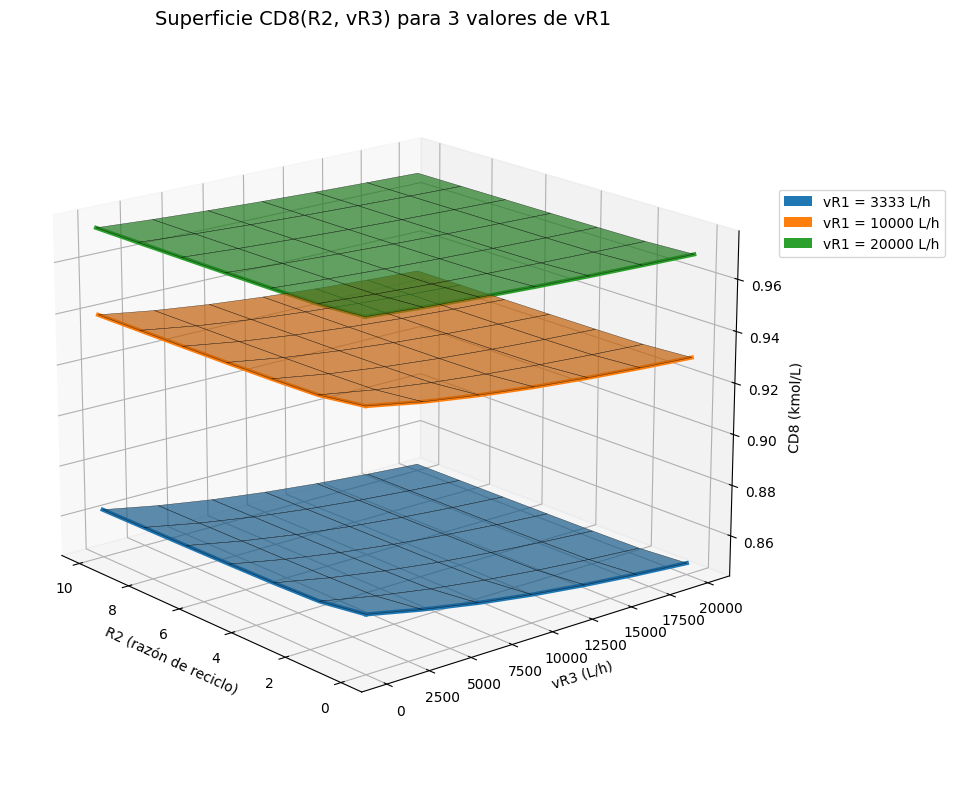

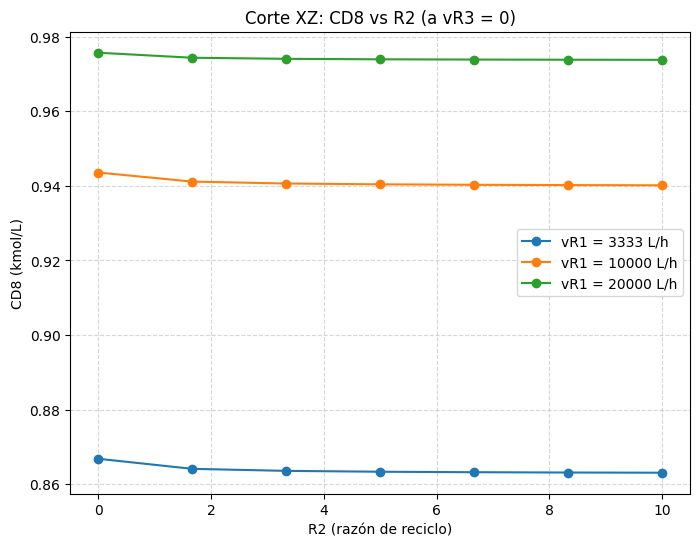

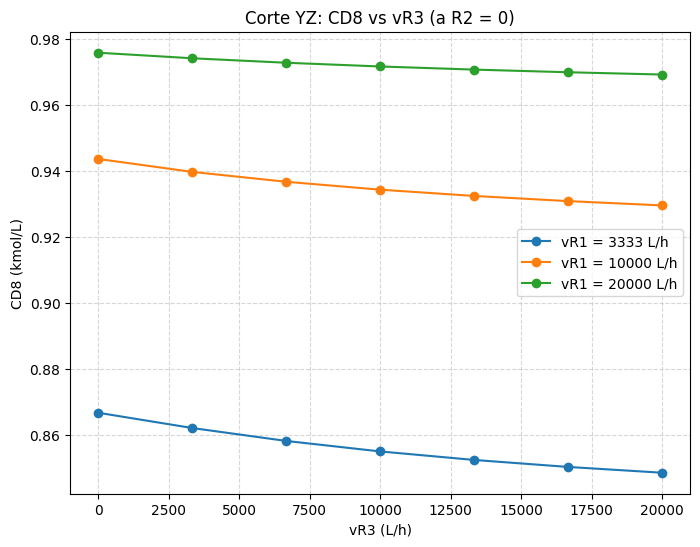

In [254]:
vR1_low  = vR1_vals[1]
vR1_mid  = vR1_vals[len(vR1_vals)//2]
vR1_high = vR1_vals[-1]
vR1_selected = [vR1_low, vR1_mid, vR1_high]
colors = ['#1f77b4', '#ff7f0e','#2ca02c']
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
R2_grid, vR3_grid = np.meshgrid(R2_vals, vR3_vals)
legend_elements = []
for i, vR1 in enumerate(vR1_selected):
    Z = np.zeros_like(R2_grid)
    for i_R2, R2 in enumerate(R2_vals):
        for i_vR3, vR3 in enumerate(vR3_vals):
            key = (vR1, R2, vR3)
            if key in dict_results:
                Z[i_vR3, i_R2] = dict_results[key][3]
            else:
                Z[i_vR3, i_R2] = np.nan
    ax.plot_surface(
        R2_grid, vR3_grid, Z,
        color=colors[i],
        alpha=0.7,
        edgecolor='k',
        linewidth=0.3
    )
    ax.plot(R2_vals*0, vR3_vals, Z[:,0], color=colors[i], linewidth=3)
    ax.plot(R2_vals, vR3_vals*0, Z[0,:], color=colors[i], linewidth=3)
    legend_elements.append(Patch(facecolor=colors[i], label=f"vR1 = {vR1:.0f} L/h"))
ax.set_xlabel("R2 (razón de reciclo)")
ax.set_ylabel("vR3 (L/h)")
ax.set_zlabel("CD8 (kmol/L)")
ax.set_title("Superficie CD8(R2, vR3) para 3 valores de vR1", fontsize=14)
ax.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(1.02, 0.8))
ax.view_init(elev=18, azim=-40)
ax.invert_xaxis()
plt.tight_layout()
plt.show()
plt.figure(figsize=(8,6))
vR3_fixed = 0.0
for i, vR1 in enumerate(vR1_selected):
    CD8_vals = []
    for R2 in R2_vals:
        key = (vR1, R2, vR3_fixed)
        CD8_vals.append(dict_results[key][3])
    plt.plot(R2_vals, CD8_vals, marker='o', label=f"vR1 = {vR1:.0f} L/h")
plt.xlabel("R2 (razón de reciclo)")
plt.ylabel("CD8 (kmol/L)")
plt.title("Corte XZ: CD8 vs R2 (a vR3 = 0)")
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.show()
plt.figure(figsize=(8,6))
R2_fixed = 0.0
for i, vR1 in enumerate(vR1_selected):
    CD8_vals = []
    for vR3 in vR3_vals:
        key = (vR1, R2_fixed, vR3)
        CD8_vals.append(dict_results[key][3])
    plt.plot(vR3_vals, CD8_vals, marker='o', label=f"vR1 = {vR1:.0f} L/h")
plt.xlabel("vR3 (L/h)")
plt.ylabel("CD8 (kmol/L)")
plt.title("Corte YZ: CD8 vs vR3 (a R2 = 0)")
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.show()